<a href="https://colab.research.google.com/github/TAUforPython/BioMedAI/blob/main/ML%20ECG%20classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Baseline

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_decision_regions

In [2]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna(axis='columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='hist')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('%.1f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Таблица анализа данных, коэффициент корреляции')
    plt.show()

In [3]:
def decision_boundary_plot(X, y, X_train, y_train, clf, feature_indexes, title=None):
    feature1_name, feature2_name = X.columns[feature_indexes]
    X_feature_columns = X.values[:, feature_indexes]
    X_train_feature_columns = X_train[:, feature_indexes]
    clf.fit(X_train_feature_columns, y_train)

    plot_decision_regions(X=X_feature_columns, y=y.values, clf=clf)
    plt.xlabel(feature1_name)
    plt.ylabel(feature2_name)
    plt.title(title)

# Загрузка, очистка и визуализация данных

Пример - медицина - дата сет кардиология:
выгружено и предобработано MIMIC-IV-ECG/ Diagnostic Electrocardiogram Matched Subset v1.0

Столбец **Healthy_Status**: 0 = пациент, 1 - условно здоровый.

https://physionet.org/content/mimic-iv-ecg/1.0/

Декодированы метки времени, добавлен признак Healthy_Status

Полезная ссылка на понимание ЭКГ: https://ecgwaves.com/topic/ecg-normal-p-wave-qrs-complex-st-segment-t-wave-j-point/

Полный датасет ECG_array_arrow_data.csv:

https://drive.google.com/file/d/1-Z2Yvcl7J8ZhdSp-MEqTHfzdrhbSdcdB/view?usp=share_link


In [4]:
table_data = pd.read_csv('https://raw.githubusercontent.com/TAUforPython/BioMedAI/main/test_datasets/test_data_ECG.csv', nrows=5000)
print(table_data)

      subject_id  Count_subj  study_id  cart_id  Healthy_Status eeg_time   \
0       19557662          27  40000017  6848296               0   8:44 AM   
1       18477137          93  40000029  6848296               0   9:54 AM   
2       16598616           3  40000035  6376932               1   9:07 AM   
3       16368287           7  40000079  6214760               1   5:14 PM   
4       18370366           2  40000084  6632385               0   1:52 PM   
...          ...         ...       ...      ...             ...       ...   
4995    12651069          44  40063447  6784628               0   8:37 AM   
4996    14893545          13  40063456  6228136               0  12:41 PM   
4997    13168569          11  40063475  6187602               0   2:53 PM   
4998    17970218           4  40063476  6332886               0   9:35 AM   
4999    10911645           1  40063483  6632385               0  11:39 AM   

       eeg_date                                            report_0  \
0   

In [3]:
# make new dataset from old columns
table_data = table_data[['Healthy_Status', 'rr_interval','p_end','qrs_onset','qrs_end','p_axis','qrs_axis','t_axis']].copy()
table_data.head()

Healthy_Status  rr_interval  p_end  qrs_onset  qrs_end  p_axis  qrs_axis  \
0               0          659    128        170      258      81        77   
1               0          722    124        162      246      77        75   
2               1          600    130        162      244      79        72   
3               1          659    146        180      254      79        66   
4               0          659  29999        504      590      84        80   

   t_axis  
0      79  
1      70  
2      77  
3      69  
4      77

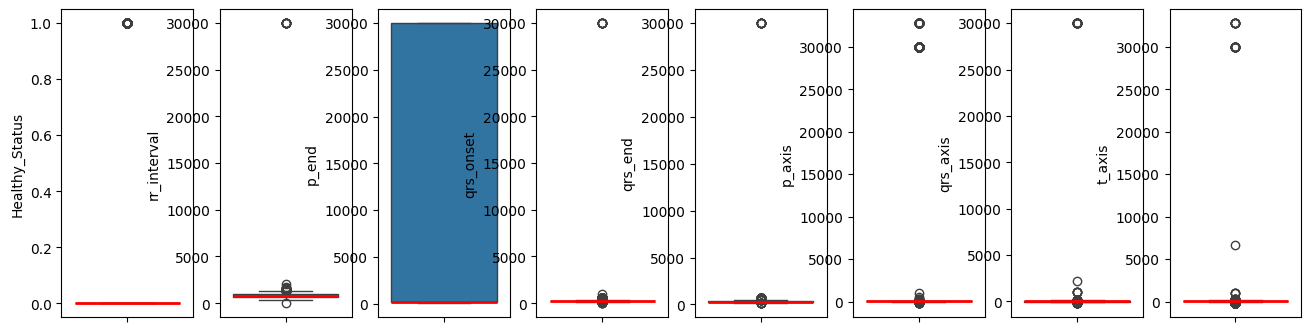

In [4]:
n = table_data.shape[1]
fig,ax = plt.subplots(1,n, figsize=(n*2,4), sharex=True)
for i in range(n):
    plt.sca(ax[i])
    col = table_data.columns[i]
    sns.boxplot(y = table_data.iloc[:,i],data=table_data, medianprops={"color": "r", "linewidth": 2})

In [5]:
# удаляем аномалии из данных (убрать все значения более 5000)
#table_data = table_data.drop(table_data[table_data['qrs_axis'] > 5000].index)
for i, v in enumerate(table_data):
  table_data = table_data.drop(table_data[table_data.iloc[:,i] > 10000].index)

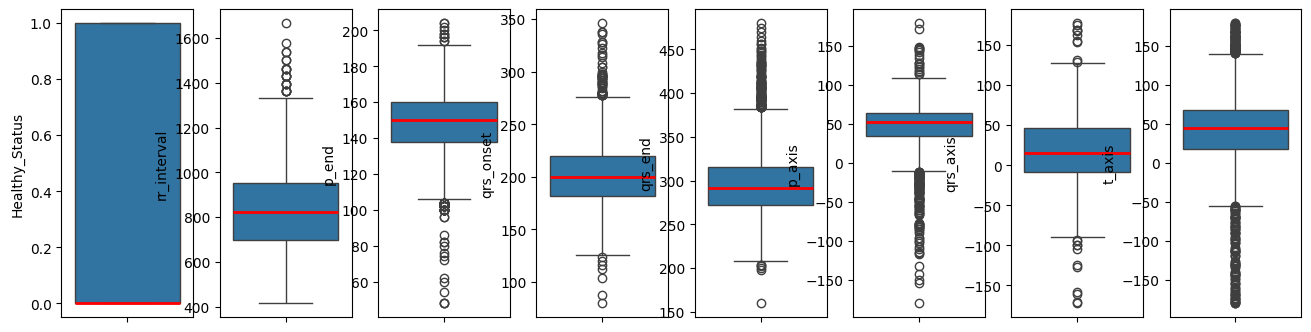

In [6]:
n = table_data.shape[1]
fig,ax = plt.subplots(1,n, figsize=(n*2,4), sharex=True)
for i in range(n):
    plt.sca(ax[i])
    col = table_data.columns[i]
    sns.boxplot(y = table_data.iloc[:,i],data=table_data,
                medianprops={"color": "r", "linewidth": 2})
    plt.tight_layout

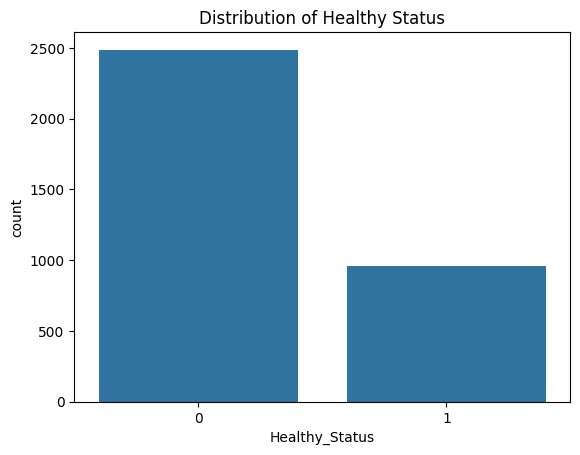

In [ ]:
sns.countplot(data=table_data, x="Healthy_Status")
plt.title("Distribution of Healthy Status")
plt.show()

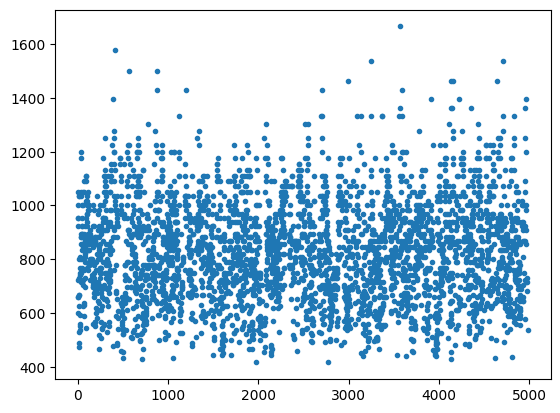

In [ ]:
#example view
plt.plot(table_data['rr_interval'],'.')

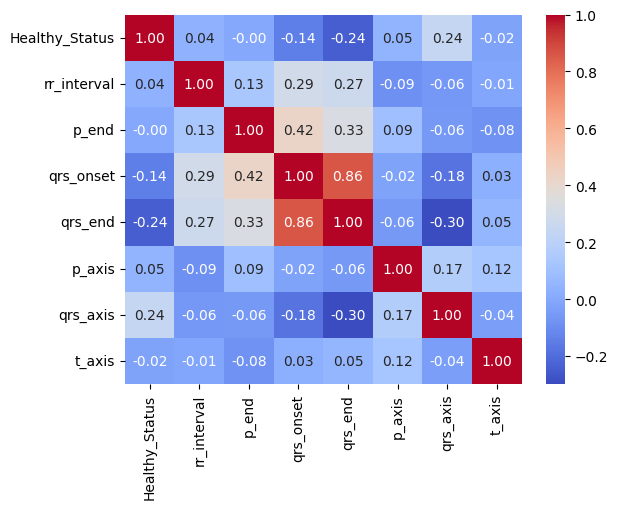

In [ ]:
sns.heatmap(table_data.corr(),annot=True,fmt="0.2f",cmap="coolwarm")
plt.show()

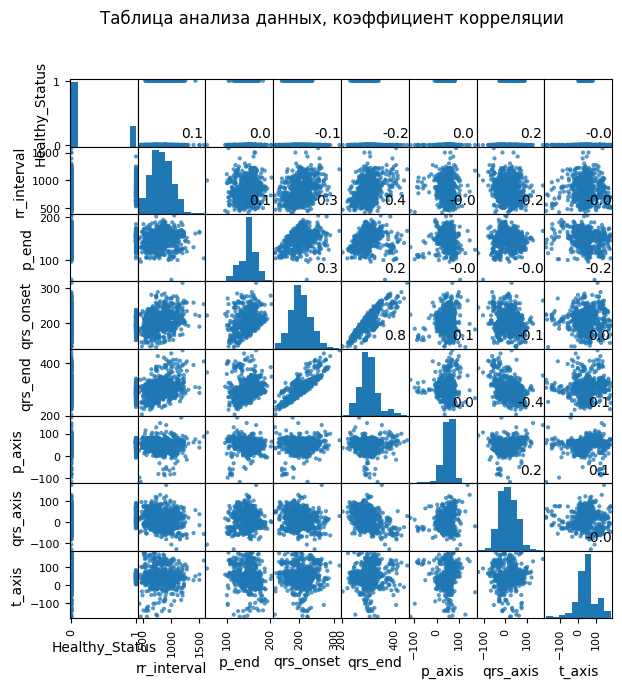

In [ ]:
plotScatterMatrix(table_data, 7, 10)

<Axes: xlabel='rr_interval', ylabel='p_axis'>

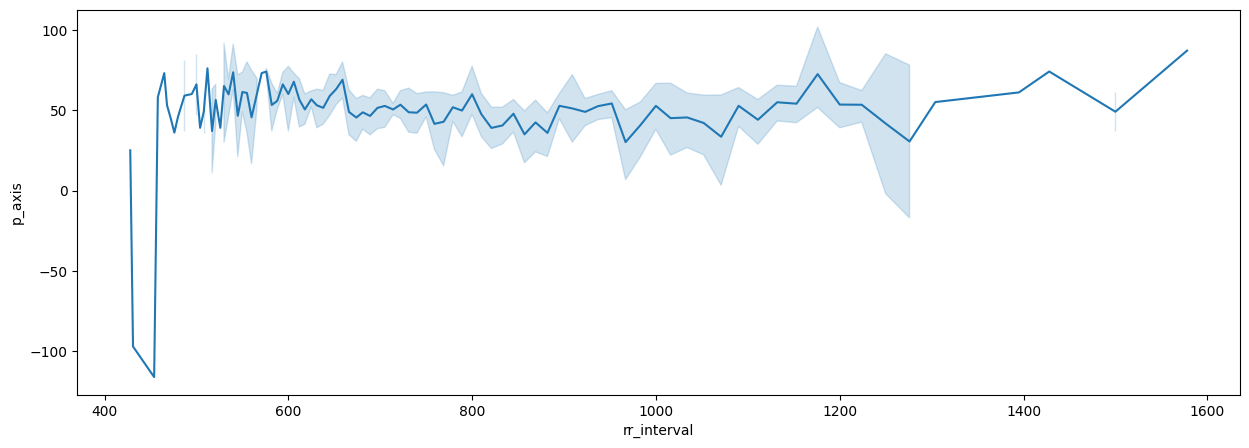

In [ ]:
fig,ax = plt.subplots(figsize=(15,5))
#sns.lineplot(x='age',y='debtinc',data=table_data,ax=ax)
sns.lineplot(x='rr_interval',y='p_axis',data=table_data,ax=ax)

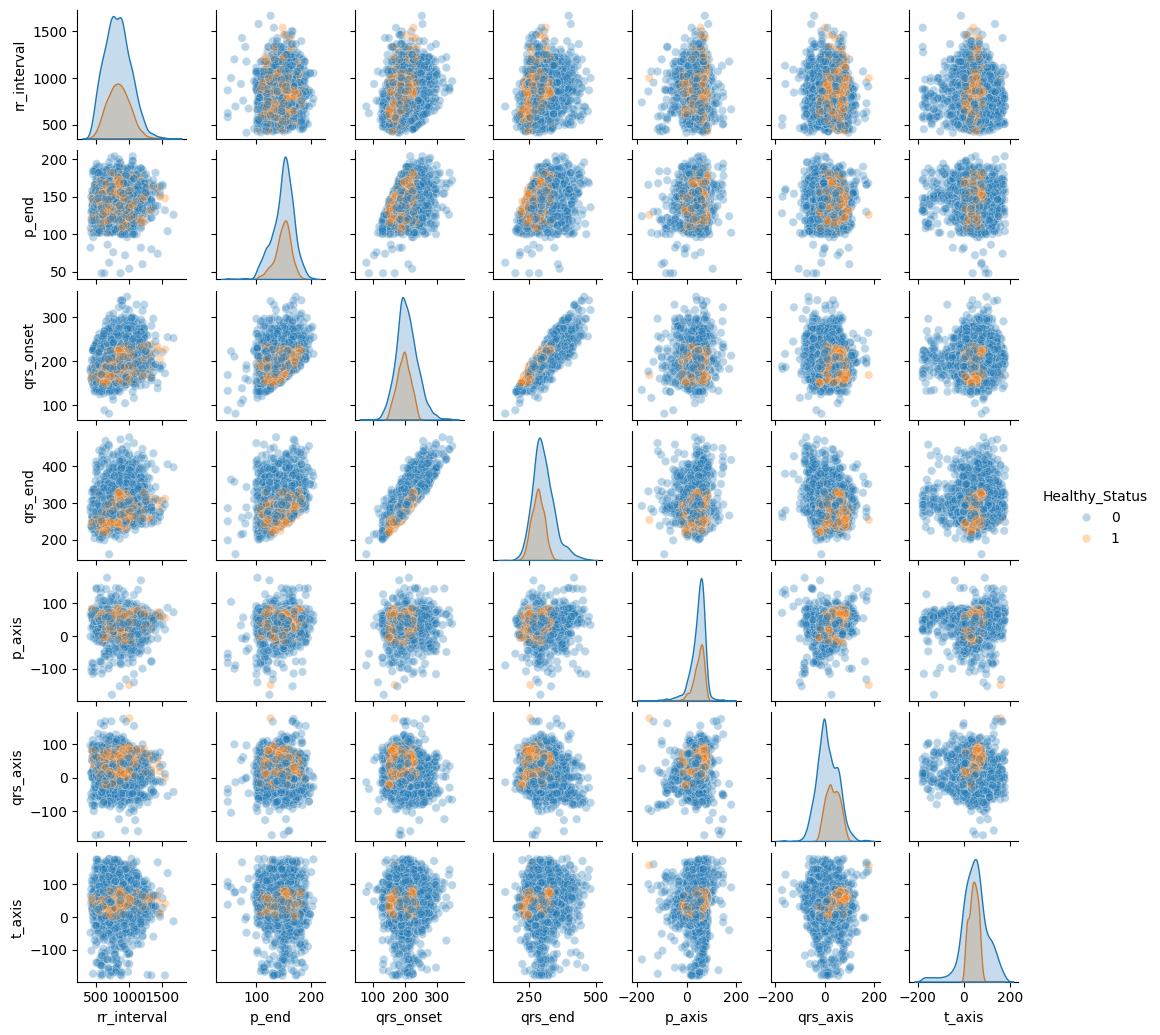

In [ ]:
#labels = pd.DataFrame(table_data['Healthy_Status'])
sns.pairplot(table_data, hue = "Healthy_Status",
             height=1.5,
             plot_kws=dict(alpha=0.3))

<Axes: xlabel='rr_interval', ylabel='qrs_end'>

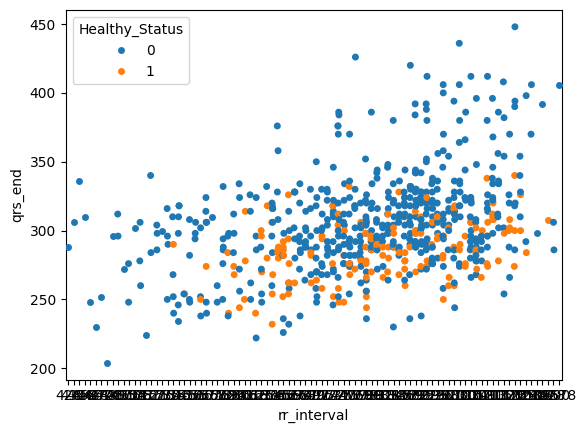

In [ ]:
sns.stripplot(x=table_data['rr_interval'],y=table_data['qrs_end'],
              hue=table_data['Healthy_Status'],jitter=True)

<Axes: xlabel='rr_interval'>

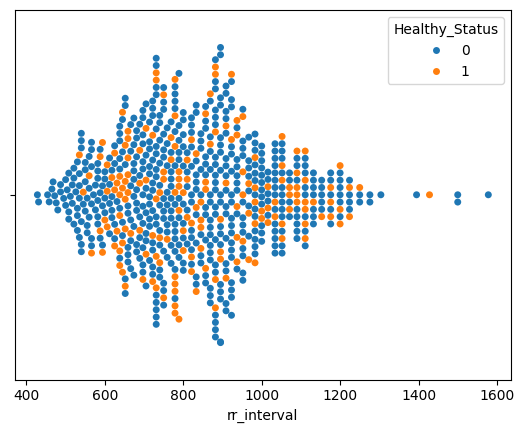

In [ ]:
sns.swarmplot(data=table_data, x="rr_interval", hue="Healthy_Status")

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


2024-09-29 16:45:00,950 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


2024-09-29 16:45:00,964 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


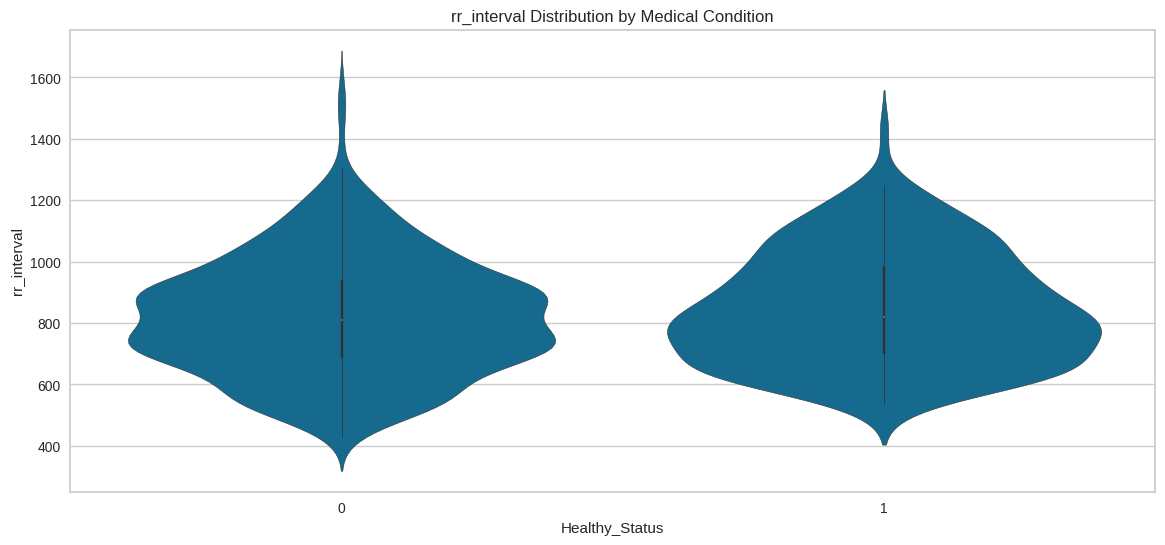

In [ ]:
plt.figure(figsize=(14, 6))
sns.violinplot(data=table_data, y='rr_interval', x='Healthy_Status')
plt.title('rr_interval Distribution by Medical Condition')
plt.show()

https://www.kaggle.com/code/ellecf/visualizing-multidimensional-clusters

# ML - Описание классов и матрица ошибок GussianClassifier

In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
table_data.columns

Index(['Healthy_Status', 'rr_interval', 'p_onset', 'p_end', 'qrs_onset',
       'qrs_end', 'p_axis', 'qrs_axis'],
      dtype='object')

In [ ]:
# set the classification index of table
clf_index = 0

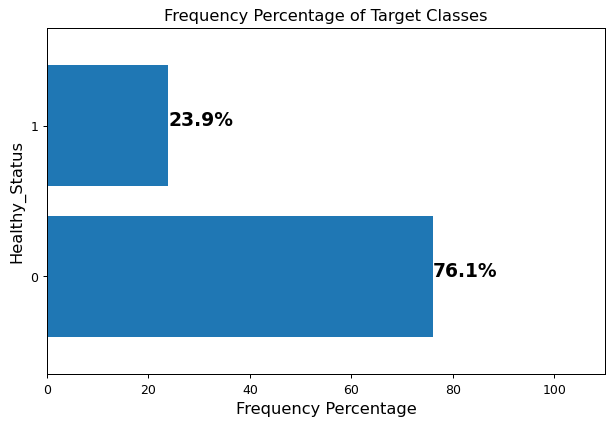

In [ ]:
plt.figure(figsize=(35,20),dpi=90)
# Plot frequency percentages barplot
table_data[table_data.columns[clf_index]].value_counts(normalize=True).mul(100).plot(kind='barh', width=0.8, figsize=(8,5))

# Add frequency percentages to the plot
labels = table_data[table_data.columns[clf_index]].value_counts(normalize=True).mul(100).round(1)
for i in labels.index:
    plt.text(labels[i], i, str(labels[i])+ '%', fontsize=15, weight='bold')

plt.xlim([0, 110])
plt.xlabel('Frequency Percentage', fontsize=13)
plt.ylabel(table_data.columns[clf_index], fontsize=13)
plt.title('Frequency Percentage of Target Classes', fontsize=13)
plt.show()

In [ ]:
# set the classification index of table
clf_index = 0

# classification variable
y1 = table_data.iloc[:, clf_index]
# input variable
X1 = table_data.drop(table_data.columns[[clf_index]], axis=1).iloc[:,:]

y1 = pd.Series(LabelEncoder().fit_transform(y1))
X1_train, X1_test, y1_train, y1_test = train_test_split(X1.values,
                                                        y1.values,
                                                        test_size=0.3,
                                                        random_state=0,
                                                        stratify=y1.values)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X1.values,
                                                 y1.values,
                                                 test_size=0.3,
                                                 random_state=41,
                                                 stratify=y1.values)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (492, 7)
y_train shape: (492,)
X_test shape: (212, 7)
y_test shape: (212,)


In [ ]:
GussianClassifier = GaussianNB()
GussianClassifier.fit(X1_train,y1_train)
y_pred=GussianClassifier.predict(X_test)
print("===================================> Result <===================================")
print("Accuracy                     = " ,metrics.accuracy_score(y_test,y_pred))
print("F1 Score                     = " ,metrics.f1_score(y_test,y_pred))

===================================> Result <===================================
Accuracy                     =  0.7783018867924528
F1 Score                     =  0.5840707964601771


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

              precision    recall  f1-score   support

        True       0.88      0.82      0.85       161
       False       0.53      0.65      0.58        51

    accuracy                           0.78       212
   macro avg       0.71      0.73      0.72       212
weighted avg       0.80      0.78      0.79       212



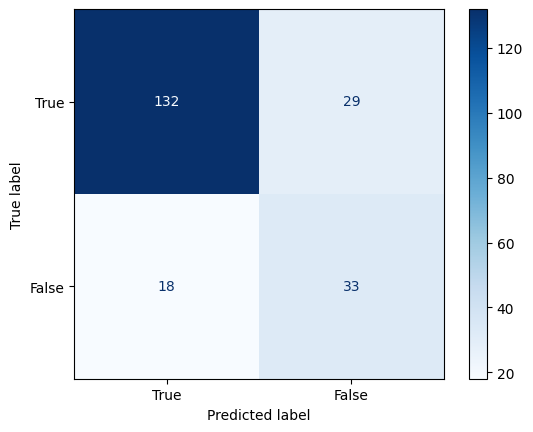

In [ ]:
target_names = ['True', 'False']
labels_names = [0,1]
print(classification_report(y_test, y_pred,labels=labels_names, target_names=target_names))
#cm = confusion_matrix(y_test, y_pred,labels=labels_names,normalize='true')
cm = confusion_matrix(y_test, y_pred,labels=labels_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
disp = disp.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()

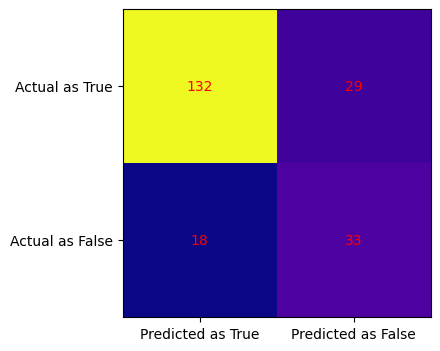

In [ ]:
cm = confusion_matrix(y_test,GussianClassifier.predict(X_test))

fig , ax  = plt.subplots(figsize=(4,4))
ax.imshow(cm, cmap = 'plasma')
ax.grid(False)
ax.xaxis.set(ticks=(0,1),ticklabels=("Predicted as True","Predicted as False"))
ax.yaxis.set(ticks=(0,1),ticklabels=("Actual as True","Actual as False"))
ax.set_ylim(1.5,-0.5)
for i in range(2):
    for j in range(2):
        ax.text(j,i,cm[i,j],ha="center",va="center",color = "red")

# AutoML BlueCast

https://www.kaggle.com/code/thomasmeiner/ps3e24-bluecast-eda-automl-tracking

In [7]:
!pip install bluecast --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.9/175.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.4/97.4 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 2.8 MB/s eta 0:00:00


In [8]:
import numpy as np
import pandas as pd
import re


from bluecast.blueprints.cast import BlueCast
from bluecast.blueprints.cast_cv import BlueCastCV
from bluecast.config.training_config import TrainingConfig, XgboostTuneParamsConfig
from bluecast.preprocessing.custom import CustomPreprocessing
from bluecast.general_utils.general_utils import save_to_production, load_for_production

from sklearn.model_selection import StratifiedKFold, RepeatedKFold

In [9]:
#  Набор данных о неплательщиках по кредиту
table_data = pd.read_csv('https://raw.githubusercontent.com/TAUforPython/BioMedAI/main/test_datasets/test_data_ECG.csv', nrows=5000)

df = table_data

# Проверка формы набора данных
print('исходный набор данных: ',df.shape)

# Инициализация начального числа для генераторов случайных чисел
seed = 10

# Создание обучающего набора с помощью выборки pandas — видимый набор данных
train_dataset = df.sample(frac=.8, random_state=seed)
#knowledge.reset_index(inplace=True, drop=True)
print('выделяем из исходного набора данныз базу для обучения: ', train_dataset.shape)

# Использование образцов, недоступных в обучающем наборе, в качестве будущего или невидимого набора данных
test_dataset = df.drop(train_dataset.index)
#payload.reset_index(inplace=True, drop=True)
print('набор данных для проверки: ',test_dataset.shape)


исходный набор данных:  (5000, 36)
выделяем из исходного набора данныз базу для обучения:  (4000, 36)
набор данных для проверки:  (1000, 36)


In [10]:
# Предобрабатываем данные

full_df = df

# Убираем выбросы
columns_to_filter = ['rr_interval', 'p_onset', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis']
#columns_to_filter = ['rr_interval', 'p_end', 'qrs_onset', 'qrs_end', 'p_axis', 'qrs_axis', 't_axis']
full_df_filtered = full_df[(full_df[columns_to_filter] < 2000).all(axis=1)]
full_df_filtered = full_df_filtered[(full_df_filtered['p_onset'] < full_df_filtered['p_end']) & (full_df_filtered['qrs_onset'] < full_df_filtered['qrs_end'])]

# Слепляем все текстовые отчеты в один большой
reports = [f'report_{x}' for x in range(18)]
full_df_filtered['report_0'] = full_df_filtered[reports].astype(str).agg(' '.join, axis=1)
full_df_filtered['report_0'] = full_df_filtered['report_0'].str.replace(r'\bnan\b', '', regex=True).str.replace(r'\s+', ' ', regex=True).str.strip()
full_df_filtered.rename(columns={'report_0': 'report'}, inplace=True)
reports_to_drop = [f'report_{x}' for x in range(1, 18)]
full_df_filtered = full_df_filtered.drop(reports_to_drop, axis=1)

# Фиксим имена столбцов
full_df_filtered = full_df_filtered.rename(columns={'eeg_time ': 'eeg_time', 'eeg_date ': 'eeg_date'})

# Делаем колонку с таргетами крайней справа
full_df_filtered = full_df_filtered[[col for col in full_df_filtered.columns if col != 'Healthy_Status'] + ['Healthy_Status']]

full_df_filtered.head()

subject_id  Count_subj  study_id  cart_id  eeg_time    eeg_date  \
0    19557662          27  40000017  6848296   8:44 AM  27.06.2015   
1    18477137          93  40000029  6848296   9:54 AM  27.06.2015   
2    16598616           3  40000035  6376932   9:07 AM  28.06.2015   
3    16368287           7  40000079  6214760   5:14 PM  15.07.2015   
6    12576058          43  40000115  6852956  12:54 PM  23.03.2016   

                                              report     bandwidth  \
0  Sinus rhythm Possible right atrial abnormality...  0.005-150 Hz   
1  Sinus rhythm Possible right atrial abnormality...  0.005-150 Hz   
2       Sinus tachycardia Normal ECG except for rate  0.005-150 Hz   
3                            Sinus rhythm Normal ECG  0.005-150 Hz   
6                            Sinus rhythm Normal ECG  0.005-150 Hz   

                     filtering  rr_interval  p_onset  p_end  qrs_onset  \
0  60 Hz notch Baseline filter          659       40    128        170   
1  60 Hz notch Baseline filter          722       40    124        162   
2  60 Hz notch Baseline filter          600       40    130        162   
3  60 Hz notch Baseline filter          659       40    146        180   
6  60 Hz notch Baseline filter          952       40    146        198   

   qrs_end  t_end  p_axis  qrs_axis  t_axis  Healthy_Status  
0      258    518      81        77      79               0  
1      246    504      77        75      70               0  
2      244    474      79        72      77               1  
3      254    538      79        66      69               1  
6      282    598      24        80      20               1

In [11]:
target = 'Healthy_Status'

In [12]:
from bluecast.preprocessing.feature_types import FeatureTypeDetector

feat_type_detector = FeatureTypeDetector()
train_data = feat_type_detector.fit_transform_feature_types(train_dataset)

len(feat_type_detector.num_columns)

14

In [13]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 245 to 1794
Data columns (total 36 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   subject_id      4000 non-null   int64  
 1   Count_subj      4000 non-null   int64  
 2   study_id        4000 non-null   int64  
 3   cart_id         4000 non-null   int64  
 4   Healthy_Status  4000 non-null   int64  
 5   eeg_time        4000 non-null   object 
 6   eeg_date        4000 non-null   object 
 7   report_0        4000 non-null   object 
 8   report_1        3010 non-null   object 
 9   report_2        2614 non-null   object 
 10  report_3        1951 non-null   object 
 11  report_4        1151 non-null   object 
 12  report_5        604 non-null    object 
 13  report_6        280 non-null    object 
 14  report_7        126 non-null    object 
 15  report_8        54 non-null     object 
 16  report_9        12 non-null     object 
 17  report_10       9 non-null      obje

In [14]:
from bluecast.eda.analyse import (
    bi_variate_plots,
    correlation_heatmap,
    correlation_to_target,
    plot_pca,
    plot_theil_u_heatmap,
    plot_tsne,
    univariate_plots,
    check_unique_values,
    plot_null_percentage
)

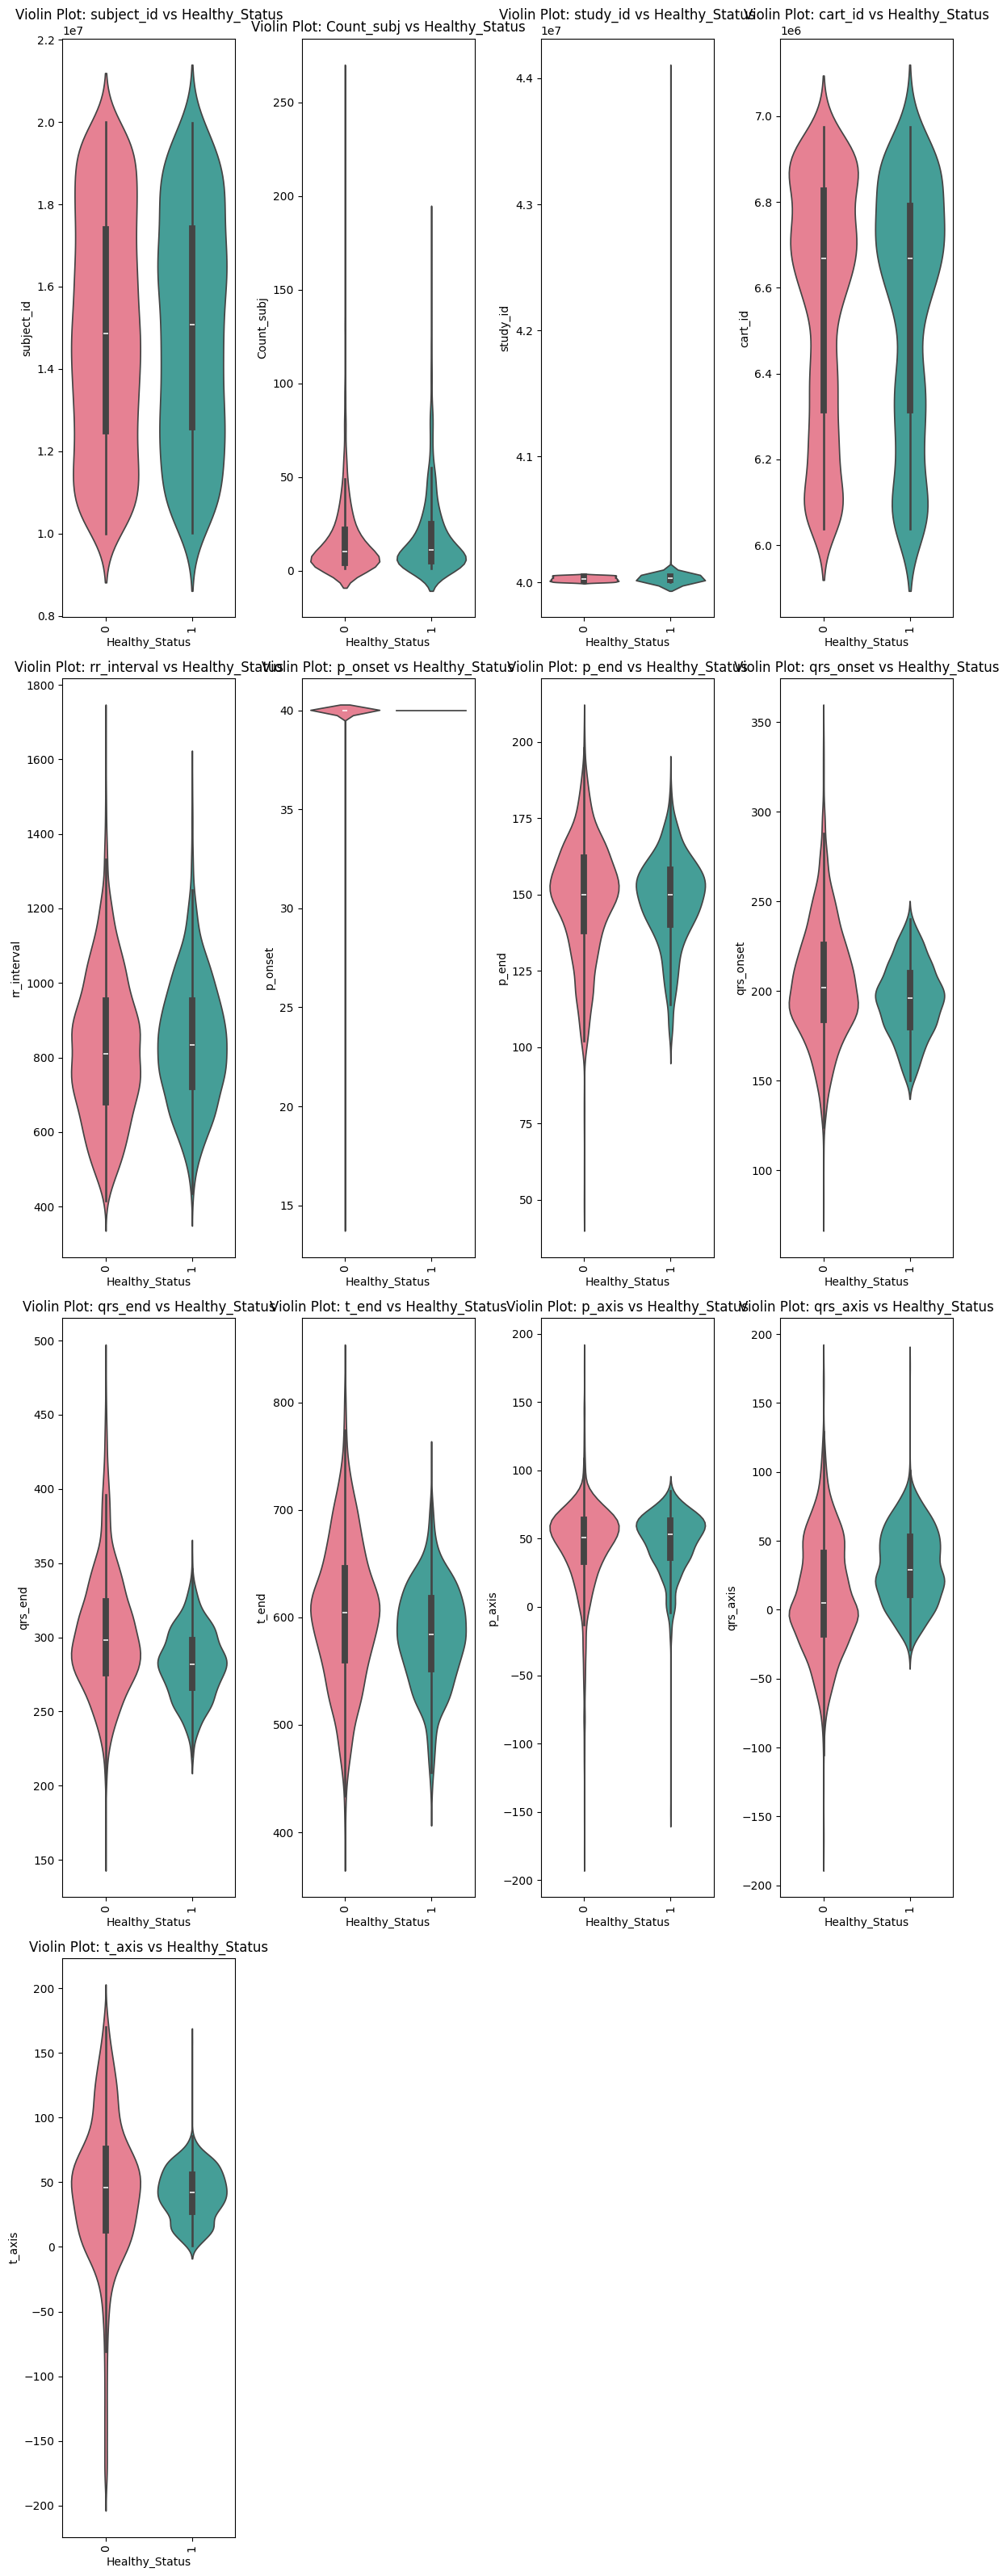

In [15]:
bi_variate_plots(
        full_df_filtered.loc[
            :, feat_type_detector.num_columns
        ],
        target,
    )

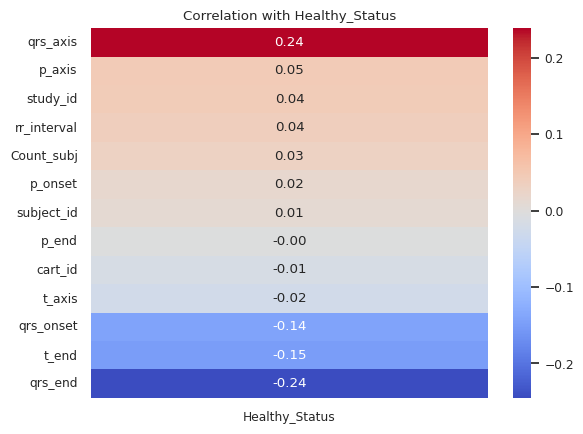

In [16]:
# show correlation to target
correlation_to_target(
    full_df_filtered.loc[:, feat_type_detector.num_columns],
      target,
      )

In [22]:
#no_correlation = ["p_axis", "p_end", "t_axis"]

no_correlation = ["p_onset", "subject_id", "p_end", "cart_id", "Count_subj"]

train = full_df_filtered.drop(no_correlation, axis=1)
test = full_df_filtered.drop(no_correlation, axis=1)

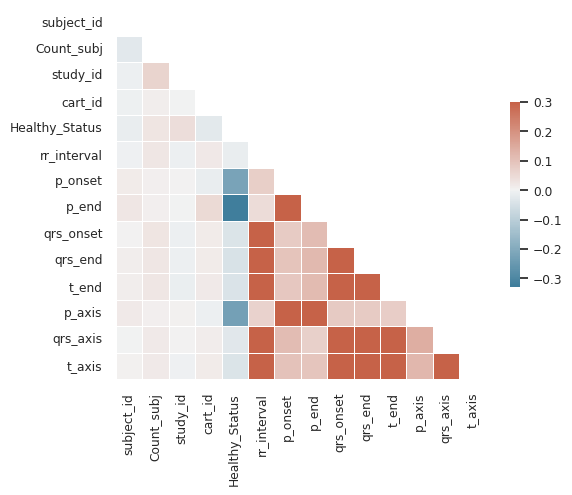

In [23]:
correlation_heatmap(train_data.loc[
            :, feat_type_detector.num_columns])

In [ ]:
# show feature space after principal component analysis
plot_pca(full_df_filtered.loc[
            :, feat_type_detector.num_columns
        ].fillna(0), target)

In [ ]:
# show feature space after t-SNE
plot_tsne(train_data.loc[
            :, feat_type_detector.num_columns
        ].sample(500, random_state=42).fillna(0), target, perplexity=30, random_state=0)

In [27]:
from bluecast.eda.data_leakage_checks import (
    detect_categorical_leakage,
    detect_leakage_via_correlation,
)

In [28]:
# Detect leakage of numeric columns based on correlation
numresult = detect_leakage_via_correlation(
        train_data.loc[:, feat_type_detector.num_columns].fillna(0), target, threshold=0.9 # target column is part of detected numerical columns here
    )

No leakage has been detected


In [ ]:
# Detect leakage of categorical columns based on Theil's U
result = detect_categorical_leakage(
        train_data.loc[:, feat_type_detector.cat_columns + [target]], target, threshold=0.9
    )

No leakage has been detected


In [29]:
# Группировка

full_df = full_df.sort_values(by='subject_id', ascending=True)
full_df = full_df["subject_id"].unique()

In [30]:
# Превращаем столбец с текстовым отчетом в число с помощью Word2Vec
from gensim.models import Word2Vec
# Разбиваем столбец с текстовым отчетом на токены
words = [text.split() for text in full_df_filtered['report']]

# Обучаем модель Word2Vec
w2v_model = Word2Vec(words)

# Функция для получения среднего эмбеддинга строки
def get_sentence_embedding(sentence):
    words = sentence.split()
    word_vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)  # Усреднённый вектор
    else:
        return np.zeros(w2v_model.vector_size)  # Нулевой вектор, если слова нет в модели

# Применяем функцию ко всей колонке и переводим каждый вектор в одно число
full_df_filtered['report'] = full_df_filtered['report'].apply(lambda x: get_sentence_embedding(x).mean())

full_df_filtered.head()

subject_id  Count_subj  study_id  cart_id  eeg_time    eeg_date    report  \
0    19557662          27  40000017  6848296   8:44 AM  27.06.2015  0.012302   
1    18477137          93  40000029  6848296   9:54 AM  27.06.2015  0.012302   
2    16598616           3  40000035  6376932   9:07 AM  28.06.2015  0.035264   
3    16368287           7  40000079  6214760   5:14 PM  15.07.2015  0.022188   
6    12576058          43  40000115  6852956  12:54 PM  23.03.2016  0.022188   

      bandwidth                    filtering  rr_interval  p_onset  p_end  \
0  0.005-150 Hz  60 Hz notch Baseline filter          659       40    128   
1  0.005-150 Hz  60 Hz notch Baseline filter          722       40    124   
2  0.005-150 Hz  60 Hz notch Baseline filter          600       40    130   
3  0.005-150 Hz  60 Hz notch Baseline filter          659       40    146   
6  0.005-150 Hz  60 Hz notch Baseline filter          952       40    146   

   qrs_onset  qrs_end  t_end  p_axis  qrs_axis  t_axis  Healthy_Status  
0        170      258    518      81        77      79               0  
1        162      246    504      77        75      70               0  
2        162      244    474      79        72      77               1  
3        180      254    538      79        66      69               1  
6        198      282    598      24        80      20               1

In [31]:
# Применяем BlueCast

# Импорт библиотеки
from bluecast.blueprints.cast import BlueCast

# Убираем из датасета лишние столбцы
autoML_df = full_df_filtered[['report', 'rr_interval', 'qrs_onset', 'qrs_end', 'p_axis', 'qrs_axis', 't_axis', 'Healthy_Status']].copy()

auto_X = autoML_df.iloc[:, :autoML_df.shape[1]-1] # Признаки
auto_Y = autoML_df.iloc[:, [autoML_df.shape[1]-1]] # Таргеты

# Первое разбиние: 80% (тренировочные + валидационные) and 20% (тестовые)
auto_X_model, auto_X_test, auto_Y_model, auto_Y_test = train_test_split(auto_X, auto_Y, test_size=0.2, random_state=1828)

# Второе разбиение: 75% (тренировочные) and 25% (валидационные)
auto_X_train, auto_X_val, auto_Y_train, auto_Y_val = train_test_split(auto_X_model, auto_Y_model, test_size=0.25, random_state=2900)

# Склеиваем признаки и таргеты в один датафрейм (только для обучающей выборки)
auto_train_df = auto_X_train
auto_train_df['Healthy_Status'] = auto_Y_train

In [32]:
eval_size = 4500

full_df_filtered = full_df_filtered[['report', 'rr_interval', 'qrs_onset', 'qrs_end', 'p_axis', 'qrs_axis', 't_axis', 'Healthy_Status']].copy()

train_eval = full_df_filtered.tail(eval_size)
train_eval = train_eval.reset_index(drop=True)
target_eval = train_eval.pop('Healthy_Status')

train = full_df_filtered.head(len(auto_train_df.index) - eval_size)
train = full_df_filtered.reset_index(drop=True)
target_eval = target_eval.iloc[train_eval.index]

train_eval.head()

report  rr_interval  qrs_onset  qrs_end  p_axis  qrs_axis  t_axis
0  0.012302          659        170      258      81        77      79
1  0.012302          722        162      246      77        75      70
2  0.035264          600        162      244      79        72      77
3  0.022188          659        180      254      79        66      69
4  0.022188          952        198      282      24        80      20

In [33]:
auto_X_train = auto_X_train.reset_index(drop=True)
auto_X_val = auto_X_val.reset_index(drop=True)
auto_Y_val = auto_Y_val.reset_index(drop=True)
auto_Y_val = auto_Y_val.astype('int64')

In [34]:
auto_X_model = auto_X_model.reset_index(drop=True)
auto_Y_model = auto_Y_model.reset_index(drop=True)

In [35]:
automl = BlueCast(class_problem="binary")

automl.conf_training.hyperparameter_tuning_rounds = 2
automl.conf_training.calculate_shap_values = False
automl.conf_training.use_full_data_for_final_model = False

2024-11-20 09:41:33,841 - root - INFO - BlueCast blueprint initialized.


2024-11-20 09:41:36,372 - root - INFO - Start detecting and casting feature types.
2024-11-20 09:41:36,379 - root - INFO - Dropped the following columns as being Nulls only: [].
2024-11-20 09:41:36,383 - root - INFO - Dropped the following columns as being Nulls only: [].
2024-11-20 09:41:36,387 - root - INFO - Dropped the following columns as constants only: [].
2024-11-20 09:41:36,390 - root - INFO - Dropped the following columns as constants only: [].
2024-11-20 09:41:36,422 - root - WARNING - /usr/local/lib/python3.10/dist-packages/bluecast/blueprints/cast.py:294: UserWarning: Feature selection is disabled. Update the TrainingConfig param 'enable_feature_selection'
            to enable it or make use of a custom preprocessor to do it manually during the last mile computations step.
            Feature selection is recommended for datasets with many features (>1000). For datasets with a small amount
            of features feature selection is not recommended.
            
2024-11-

  0%|          | 0/2 [00:00<?, ?it/s]

2024-11-20 09:41:42,281 - root - INFO - New best score: 0.044476963668236294 from random seed  33
2024-11-20 09:41:42,286 - root - INFO - Best params: {'validate_parameters': False, 'objective': 'multi:softprob', 'booster': 'gbtree', 'eval_metric': 'mlogloss', 'num_class': 2, 'max_depth': 5, 'alpha': 0.0001022333074208618, 'lambda': 7.990665042252794, 'gamma': 0.03075329374811694, 'min_child_weight': 1.7691647777876995, 'subsample': 1.0, 'colsample_bytree': 0.6605019571637358, 'colsample_bylevel': 0.5712244079327145, 'eta': 0.2063016445857904, 'steps': 91, 'tree_method': 'hist', 'grow_policy': 'depthwise', 'max_bin': 998}
2024-11-20 09:41:42,289 - root - INFO - Start final model training
2024-11-20 09:41:42,438 - root - INFO - Finished training
2024-11-20 09:41:42,444 - root - INFO - Start casting feature types.
2024-11-20 09:41:42,450 - root - INFO - Dropped the following columns as being Nulls only: [].
2024-11-20 09:41:42,455 - root - INFO - Dropped the following columns as constant

Best params: {'validate_parameters': False, 'objective': 'multi:softprob', 'booster': 'gbtree', 'eval_metric': 'mlogloss', 'num_class': 2, 'max_depth': 5, 'alpha': 0.0001022333074208618, 'lambda': 7.990665042252794, 'gamma': 0.03075329374811694, 'min_child_weight': 1.7691647777876995, 'subsample': 1.0, 'colsample_bytree': 0.6605019571637358, 'colsample_bylevel': 0.5712244079327145, 'eta': 0.2063016445857904, 'steps': 91, 'tree_method': 'hist', 'grow_policy': 'depthwise', 'max_bin': 998}
Finished hyperparameter tuning


2024-11-20 09:41:42,527 - root - INFO - Finished predicting
2024-11-20 09:41:42,539 - root - INFO - The Matthew correlation is 0.9848226686621473
2024-11-20 09:41:42,544 - root - INFO - The accuracy is 0.9939095127610209
2024-11-20 09:41:42,553 - root - INFO - The recall is 0.9939095127610209
2024-11-20 09:41:42,562 - root - INFO - The macro F1 score is 0.9923893393993266
2024-11-20 09:41:42,570 - root - INFO - The micro F1 score is 0.9939095127610209
2024-11-20 09:41:42,578 - root - INFO - The weighted F1 score is 0.9938966884562176
2024-11-20 09:41:42,580 - root - INFO - The balanced logloss is 0.03833539038896561
2024-11-20 09:41:42,588 - root - INFO - The ROC auc score is 0.999246801312969
2024-11-20 09:41:42,595 - root - INFO - The log loss score is 0.027750818084801194
2024-11-20 09:41:42,612 - root - INFO -               precision    recall  f1-score   support

           0       0.99      1.00      1.00      2488
           1       1.00      0.98      0.99       960

    accura

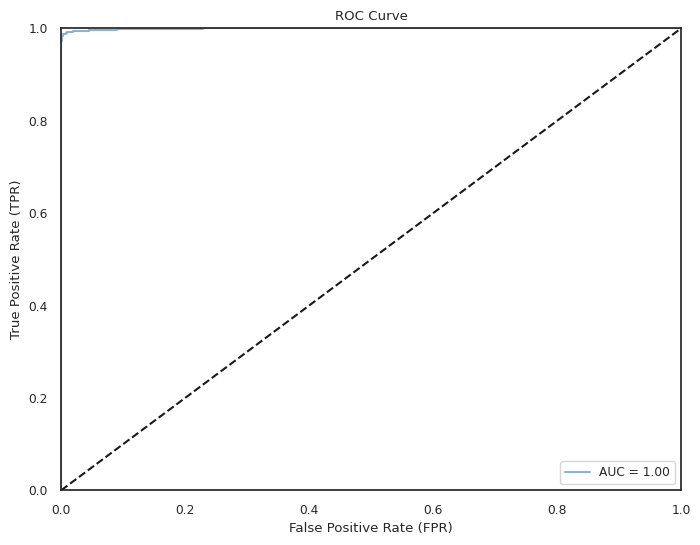

2024-11-20 09:41:42,949 - root - WARNING - /usr/local/lib/python3.10/dist-packages/bluecast/evaluation/eval_metrics.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


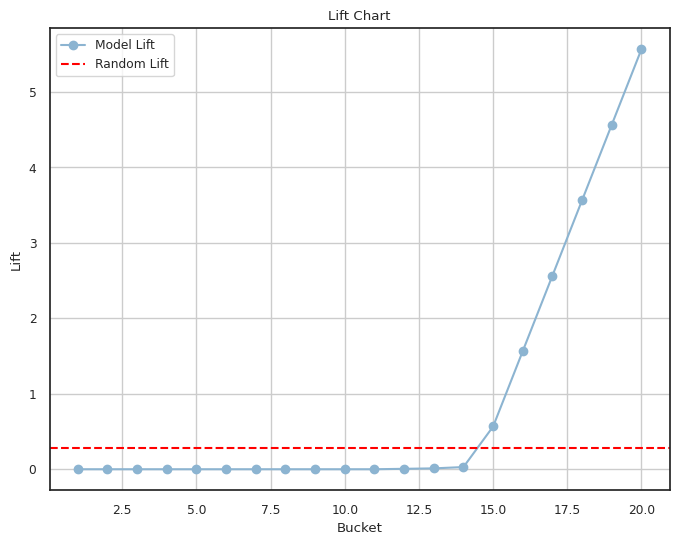

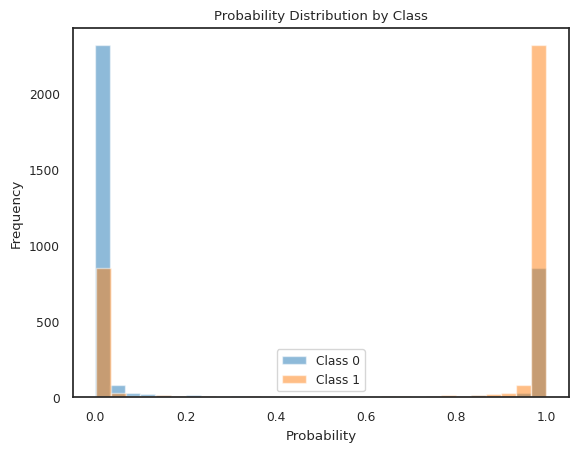

2024-11-20 09:41:43,737 - root - INFO - Start saving out of fold data.


{'matthews': 0.9848226686621473,
 'accuracy': 0.9939095127610209,
 'recall': 0.9939095127610209,
 'f1_score_macro': 0.9923893393993266,
 'f1_score_micro': 0.9939095127610209,
 'f1_score_weighted': 0.9938966884562176,
 'log_loss': 0.027750818084801194,
 'balanced_logloss': 0.03833539038896561,
 'roc_auc': 0.999246801312969,
 'classfication_report': '              precision    recall  f1-score   support\n\n           0       0.99      1.00      1.00      2488\n           1       1.00      0.98      0.99       960\n\n    accuracy                           0.99      3448\n   macro avg       0.99      0.99      0.99      3448\nweighted avg       0.99      0.99      0.99      3448\n',
 'confusion_matrix': array([[2484,    4],
        [  17,  943]])}

In [36]:
automl.fit_eval(
    df=autoML_df,
    df_eval=autoML_df.drop('Healthy_Status', axis=1),
    target_eval=autoML_df['Healthy_Status'],
    target_col="Healthy_Status",
)

2024-11-20 09:41:54,017 - root - INFO - Start detecting and casting feature types.
2024-11-20 09:41:54,021 - root - INFO - Dropped the following columns as being Nulls only: [].
2024-11-20 09:41:54,024 - root - INFO - Dropped the following columns as being Nulls only: [].
2024-11-20 09:41:54,029 - root - INFO - Dropped the following columns as constants only: [].
2024-11-20 09:41:54,031 - root - INFO - Dropped the following columns as constants only: [].
2024-11-20 09:41:54,074 - root - WARNING - /usr/local/lib/python3.10/dist-packages/bluecast/blueprints/cast.py:294: UserWarning: Feature selection is disabled. Update the TrainingConfig param 'enable_feature_selection'
            to enable it or make use of a custom preprocessor to do it manually during the last mile computations step.
            Feature selection is recommended for datasets with many features (>1000). For datasets with a small amount
            of features feature selection is not recommended.
            
2024-11-

  0%|          | 0/2 [00:00<?, ?it/s]

2024-11-20 09:42:03,414 - root - INFO - Start final model training
2024-11-20 09:42:03,559 - root - INFO - Finished training
2024-11-20 09:42:03,564 - root - INFO - Start casting feature types.
2024-11-20 09:42:03,568 - root - INFO - Dropped the following columns as being Nulls only: [].
2024-11-20 09:42:03,571 - root - INFO - Dropped the following columns as constants only: [].
2024-11-20 09:42:03,574 - root - INFO - Start filling infinite values.
2024-11-20 09:42:03,579 - root - INFO - Start date column conversion.
2024-11-20 09:42:03,582 - root - INFO - Start checking if DataFrame schema of new data is consistent with previous data.
2024-11-20 09:42:03,585 - root - INFO - Start transforming categories with binary target encoder.
2024-11-20 09:42:03,599 - root - INFO - Start transforming categories with binary target encoder.
2024-11-20 09:42:03,611 - root - INFO - Predicting...


Finished hyperparameter tuning


2024-11-20 09:42:03,613 - root - INFO - Start predicting on new data using Xgboost model.
2024-11-20 09:42:03,654 - root - INFO - Finished predicting
2024-11-20 09:42:03,661 - root - INFO - The Matthew correlation is 0.9848226686621473
2024-11-20 09:42:03,665 - root - INFO - The accuracy is 0.9939095127610209
2024-11-20 09:42:03,673 - root - INFO - The recall is 0.9939095127610209
2024-11-20 09:42:03,682 - root - INFO - The macro F1 score is 0.9923893393993266
2024-11-20 09:42:03,688 - root - INFO - The micro F1 score is 0.9939095127610209
2024-11-20 09:42:03,695 - root - INFO - The weighted F1 score is 0.9938966884562176
2024-11-20 09:42:03,697 - root - INFO - The balanced logloss is 0.03833539038896561
2024-11-20 09:42:03,704 - root - INFO - The ROC auc score is 0.999246801312969
2024-11-20 09:42:03,709 - root - INFO - The log loss score is 0.027750818084801194
2024-11-20 09:42:03,724 - root - INFO -               precision    recall  f1-score   support

           0       0.99      

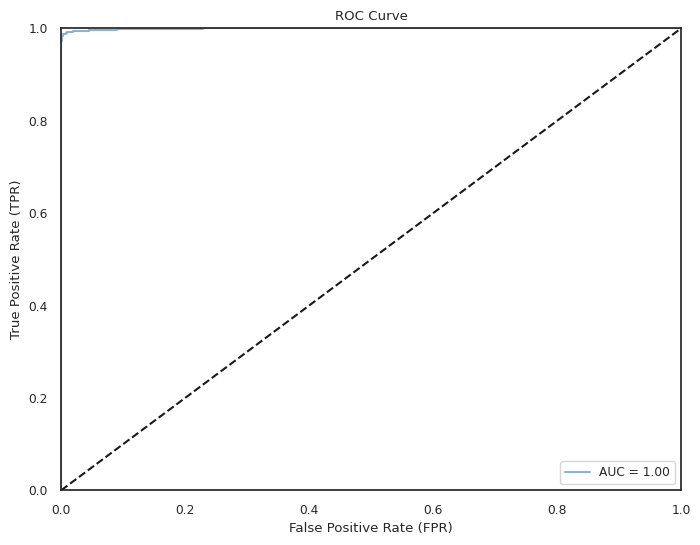

2024-11-20 09:42:04,045 - root - WARNING - /usr/local/lib/python3.10/dist-packages/bluecast/evaluation/eval_metrics.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


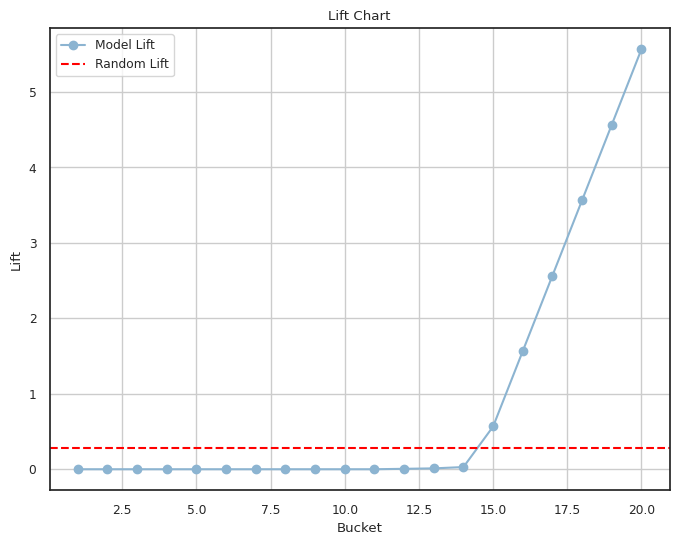

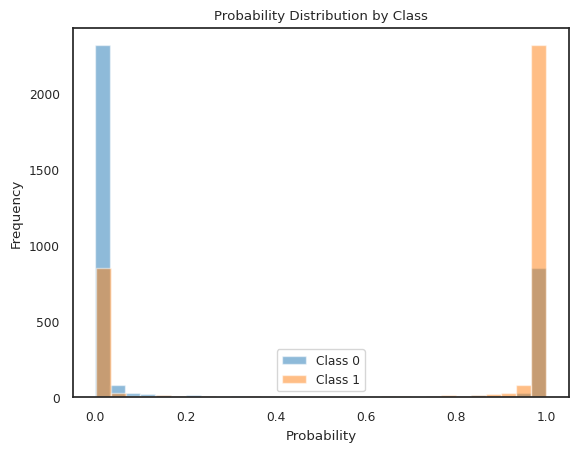

2024-11-20 09:42:05,558 - root - INFO - Start saving out of fold data.


{'matthews': 0.9848226686621473,
 'accuracy': 0.9939095127610209,
 'recall': 0.9939095127610209,
 'f1_score_macro': 0.9923893393993266,
 'f1_score_micro': 0.9939095127610209,
 'f1_score_weighted': 0.9938966884562176,
 'log_loss': 0.027750818084801194,
 'balanced_logloss': 0.03833539038896561,
 'roc_auc': 0.999246801312969,
 'classfication_report': '              precision    recall  f1-score   support\n\n           0       0.99      1.00      1.00      2488\n           1       1.00      0.98      0.99       960\n\n    accuracy                           0.99      3448\n   macro avg       0.99      0.99      0.99      3448\nweighted avg       0.99      0.99      0.99      3448\n',
 'confusion_matrix': array([[2484,    4],
        [  17,  943]])}

In [37]:
automl.fit_eval(
    df=train,
    df_eval=train_eval,
    target_eval=target_eval,
    target_col="Healthy_Status",
)

In [ ]:
# Проверяем, как обучилась наша autoML модель

# Предсказываем
y_probs, y_classes = automl.predict(auto_X_test)

# Импортируем библиотеки для вычисления точности
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

# Вычисляем F1-меру с помощью матрицы ошибок
cm = confusion_matrix(auto_Y_test, y_classes)
TN, FP, FN, TP = cm.ravel()
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
roc_auc = roc_auc_score(auto_Y_test, y_probs)

# Выводим матрицу ошибок, F1-меру и ROC AUC
print("Confusion matrix:", cm)
print("F1-Score:", f1_score)
print("ROC AUC:", roc_auc)

2024-11-18 11:50:51,381 - root - INFO - Start casting feature types.
2024-11-18 11:50:51,384 - root - INFO - Dropped the following columns as being Nulls only: [].
2024-11-18 11:50:51,386 - root - INFO - Dropped the following columns as constants only: [].
2024-11-18 11:50:51,388 - root - INFO - Start filling infinite values.
2024-11-18 11:50:51,394 - root - INFO - Start date column conversion.
2024-11-18 11:50:51,395 - root - INFO - Start checking if DataFrame schema of new data is consistent with previous data.
2024-11-18 11:50:51,402 - root - INFO - Start transforming categories with binary target encoder.
2024-11-18 11:50:51,404 - root - INFO - Start transforming categories with binary target encoder.
2024-11-18 11:50:51,410 - root - INFO - Predicting...
2024-11-18 11:50:51,412 - root - INFO - Start predicting on new data using Xgboost model.
2024-11-18 11:50:51,428 - root - INFO - Finished predicting


Confusion matrix: [[498   1]
 [  4 187]]
F1-Score: 0.9868073878627969
ROC AUC: 0.9988563514463482


# AutoML PyCaret

https://habr.com/ru/companies/ods/articles/657525/

In [ ]:
!pip install fedot --quiet

In [ ]:
from fedot.api.main import Fedot
from sklearn.metrics import classification_report, roc_auc_score

from data.data import get_train_data, get_test_data

train_features, train_target = get_train_data()
test_features, test_target = get_test_data()

# Task selection, initialisation of the framework
fedot_model = Fedot(problem='classification', timeout=timeout)

# Fit model
obtained_pipeline = fedot_model.fit(features=train_features, target=train_target)
obtained_pipeline.show()

# Make predictions
predict = fedot_model.predict(test_features)
predict_probs = fedot_model.predict_proba(test_features)

In [ ]:
!pip install pycaret --quiet

In [ ]:
from pycaret.datasets import get_data

#  Набор данных о неплательщиках по кредиту
df = table_data

# Проверка формы набора данных
print('исходный набор данных: ',df.shape)

# Инициализация начального числа для генераторов случайных чисел
seed = 10

# Создание обучающего набора с помощью выборки pandas — видимый набор данных
knowledge = df.sample(frac=.8, random_state=seed)
#knowledge.reset_index(inplace=True, drop=True)
print('выделяем из исходного набора данныз базу для обучения: ', knowledge.shape)

# Использование образцов, недоступных в обучающем наборе, в качестве будущего или невидимого набора данных
payload = df.drop(knowledge.index)
#payload.reset_index(inplace=True, drop=True)
print('набор данных для проверки: ',payload.shape)


исходный набор данных:  (704, 8)
выделяем из исходного набора данныз базу для обучения:  (563, 8)
набор данных для проверки:  (141, 8)


In [ ]:
# Задействуем волшебную функцию!
from pycaret.classification import *

# Функция setup инициализирует среду и создает конвейер преобразования
clf = setup(data=knowledge, target="Healthy_Status", session_id=123)

Processing:   0%|          | 0/69 [00:00<?, ?it/s]

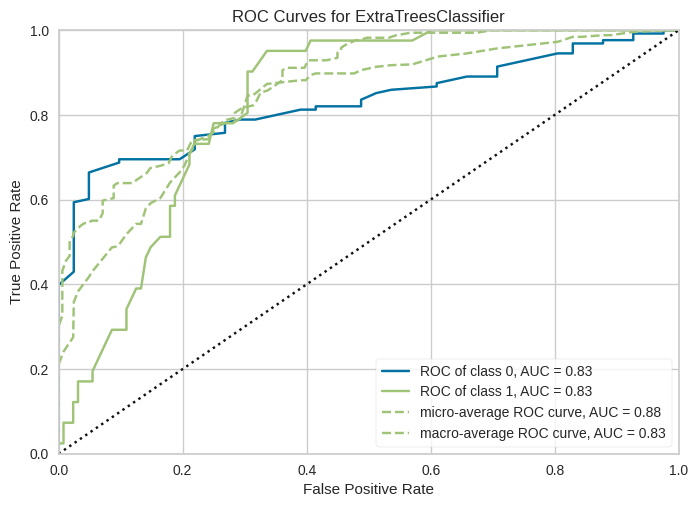

In [ ]:
# Сравниваем различные модели в зависимости от их метрик производительности. По умолчанию модели сортируются по точности
best_model = compare_models(fold=5)

# Построение кривой AUC
plot_model(best_model, plot="auc")

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


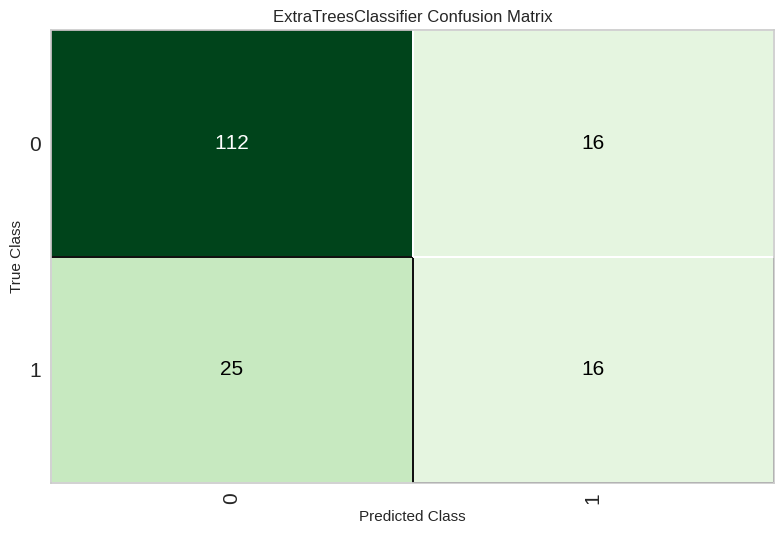

In [ ]:
# Функция Tune model выполняет сеточный поиск для определения оптимальных параметров
tuned = tune_model(best_model)
plot_model(tuned, plot="confusion_matrix")

# Прогнозирование на тестовом наборе
predict_model(tuned)

# Доработка модели путем переобучения на всем видимом наборе данных
final_model = finalize_model(tuned)

In [ ]:
# Прогнозирование на тестовом наборе
predict_model(tuned)

# Доработка модели путем переобучения на всем видимом наборе данных
final_model = finalize_model(tuned)

# Прогнозирование на невидимых данных
predictions = predict_model(final_model, data=payload)
predictions.head()

rr_interval  p_end  qrs_onset  qrs_end  p_axis  qrs_axis  t_axis  \
6           952    146        198      282      24        80      20   
10         1052    138        172      268      55       -16       2   
16          530    128        204      290      99        37     142   
18          666    168        246      328      69        26      95   
44          882    174        218      298      13       -29     -80   

    Healthy_Status  prediction_label  prediction_score  
6                1                 0              0.60  
10               0                 0              0.79  
16               0                 0              0.96  
18               0                 0              0.99  
44               0                 0              0.99

# ML GaussianNaiveBayes

In [ ]:
class GaussianNaiveBayes:
    def fit(self, X, y):
        classes, cls_counts = np.unique(y, return_counts=True)
        n_classes = len(classes)
        self.priors = cls_counts / len(y)

        # calculate the mean and standard deviations of features by classes
        self.X_cls_mean = np.array([np.mean(X[y == c], axis=0) for c in range(n_classes)])
        self.X_stds = np.array([np.std(X[y == c], axis=0) for c in range(n_classes)])

    # calculate the probability density of the feature according to the Gaussian distribution
    def pdf(self, x, mean, std):
        return (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * ((x - mean) / std) ** 2)

    def predict(self, X):
        pdfs = np.array([self.pdf(x, self.X_cls_mean, self.X_stds) for x in X])
        posteriors = self.priors * np.prod(pdfs, axis=2)   # shorten Bayes formula

        return np.argmax(posteriors, axis=1)

In [ ]:
#So, when you do [:, -1] it means you are taking all the rows and only the last column. -1 represents the last column.
#When you do [:, :-1], it means you are taking all the rows and all the columns except the last column.
#X1, y1 = table_data.iloc[:, :-1], table_data.iloc[:, -1]

In [ ]:
# set the classification index of table
clf_index = 0

# classification variable
y1 = table_data.iloc[:, clf_index]
# input variable
X1 = table_data.drop(table_data.columns[[clf_index]], axis=1).iloc[:,:]

y1 = pd.Series(LabelEncoder().fit_transform(y1))
X1_train, X1_test, y1_train, y1_test = train_test_split(X1.values,
                                                        y1.values,
                                                        test_size=0.3,
                                                        random_state=0,
                                                        stratify=y1.values)

In [ ]:
nb_clf = GaussianNaiveBayes()
nb_clf.fit(X1_train, y1_train)
nb_clf_pred_res = nb_clf.predict(X1_test)
nb_clf_accuracy = accuracy_score(y1_test, nb_clf_pred_res)

print(f'Naive Bayes classifier accucacy: {nb_clf_accuracy}')
print(nb_clf_pred_res)

Naive Bayes classifier accucacy: 0.29347198151357595
[1 1 1 ... 1 1 1]


<ipython-input-65-e61f33113988>:13: RuntimeWarning: divide by zero encountered in divide
  return (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * ((x - mean) / std) ** 2)
<ipython-input-65-e61f33113988>:13: RuntimeWarning: invalid value encountered in divide
  return (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * ((x - mean) / std) ** 2)


sk Naive Bayes classifier accucacy: 0.4119006354708261
[1 0 0 ... 1 1 1]


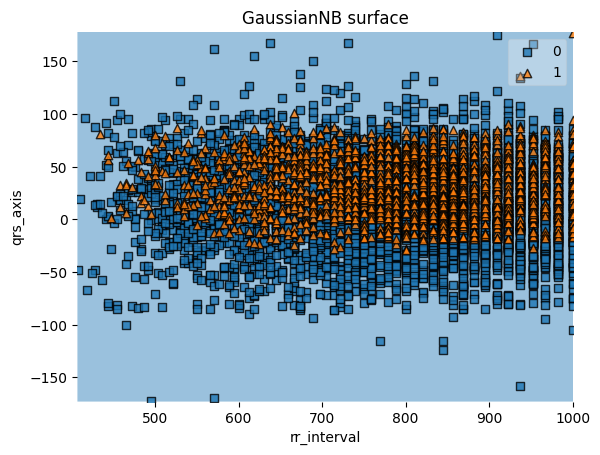

In [ ]:
sk_nb_clf = GaussianNB()
sk_nb_clf.fit(X1_train, y1_train)
sk_nb_clf_pred_res = sk_nb_clf.predict(X1_test)
sk_nb_clf_accuracy = accuracy_score(y1_test, sk_nb_clf_pred_res)

print(f'sk Naive Bayes classifier accucacy: {sk_nb_clf_accuracy}')
print(sk_nb_clf_pred_res)

feature_indexes = [0, 6]
title1 = 'GaussianNB surface'
decision_boundary_plot(X1, y1, X1_train, y1_train, sk_nb_clf, feature_indexes, title1)

# Методы PCA - princopal component analysis

https://web.archive.org/web/20090528101113/http://www.chemometrics.ru/materials/textbooks/pca.htm

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [45]:
table_data_pca = full_df_filtered
table_data_pca = table_data_pca.drop('Healthy_Status', axis = 1)
table_data_pca.columns

Index(['report', 'rr_interval', 'qrs_onset', 'qrs_end', 'p_axis', 'qrs_axis',
       't_axis'],
      dtype='object')

In [46]:
#cancer = load_breast_cancer()
# Before applying PCA, each feature should be centered (zero mean) and with unit variance
scaled_data = StandardScaler().fit(table_data_pca).transform(table_data_pca)
pca = PCA(n_components = 2).fit(scaled_data)
# PCA(copy=True, n_components=2, whiten=False)
x_pca = pca.transform(scaled_data)
print(table_data.shape, x_pca.shape)

(5000, 36) (3448, 2)


In [47]:
percent = pca.explained_variance_ratio_
print(percent)
print(sum(percent))
#To see how much variance is preserved for each dataset.

[0.30746166 0.17509064]
0.48255229752170414


In [48]:
def pca_explained(X, threshold):
  features = X.shape[1]
  for i in range(2, features):
    pca = PCA(n_components = i).fit(X)
    sum_ = pca.explained_variance_ratio_
    # add all components explained variances
    percent = sum(sum_)
    print('{} components at {:.2f}% explained variance'.format(i,percent*100))
    if percent > threshold:
      break

pca_explained(scaled_data, 0.85)

2 components at 48.26% explained variance
3 components at 64.35% explained variance
4 components at 77.68% explained variance
5 components at 88.03% explained variance


Text(0, 0.5, 'Second Principal Component')

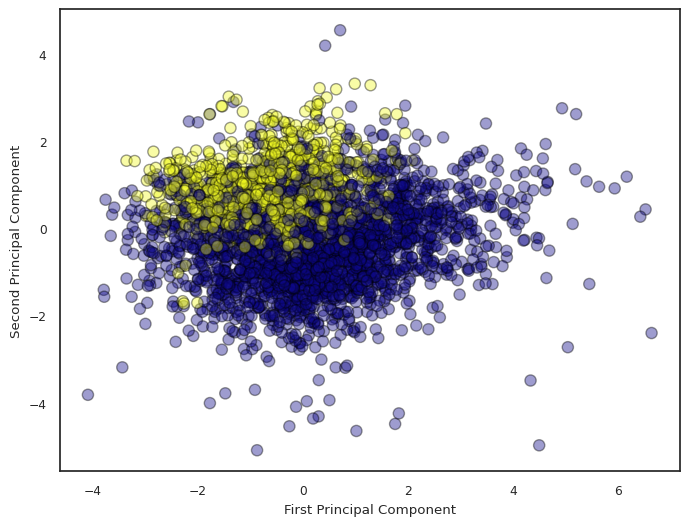

In [50]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0], x_pca[:,1], c=full_df_filtered['Healthy_Status'], cmap='plasma', alpha=0.4, edgecolors='black', s=65);
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

2024-11-20 10:03:05,465 - root - WARNING - <ipython-input-52-136a607f9ba3>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
2024-11-20 10:03:05,473 - root - WARNING - <ipython-input-52-136a607f9ba3>:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


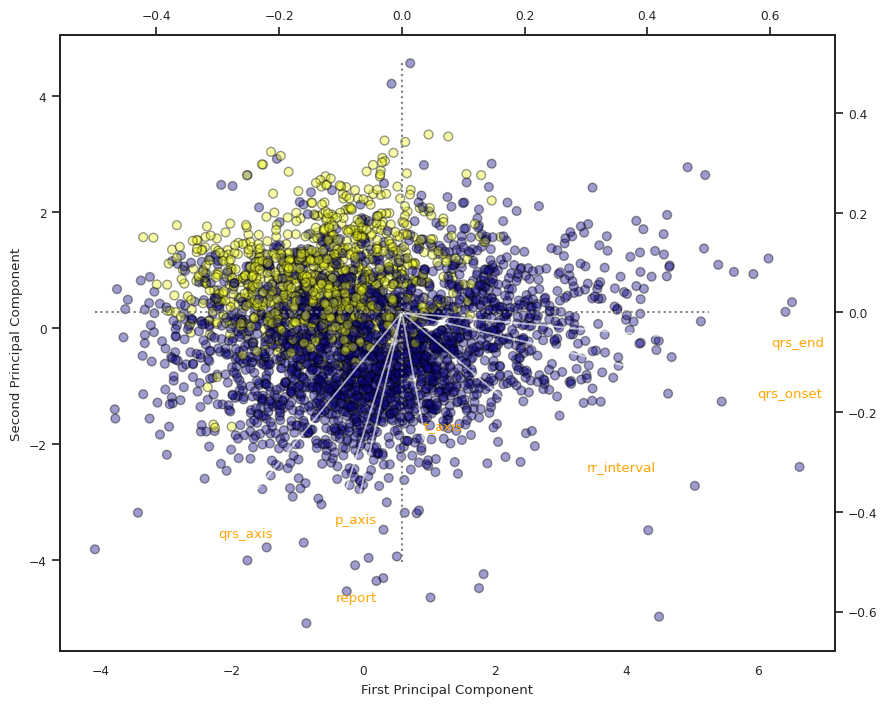

In [52]:
# put feature values into dataframe
components = pd.DataFrame(pca.components_.T, index=table_data_pca.columns, columns= ['PCA1','PCA2'])
# plot size
plt.figure(figsize=(10,8))
# main scatterplot
plt.scatter(x_pca[:,0], x_pca[:,1], c=full_df_filtered['Healthy_Status'],
            cmap='plasma', alpha=0.4, edgecolors='black', s=40);
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
#plt.ylim(15,-15);
#plt.xlim(20,-20);

# individual feature values
ax2 = plt.twinx().twiny();
#ax2.set_ylim(-0.5,0.5);
#ax2.set_xlim(-0.5,0.5);

# reference lines
ax2.hlines(0,-0.5,0.5, linestyles='dotted', colors='grey')
ax2.vlines(0,-0.5,0.5, linestyles='dotted', colors='grey')

# offset for labels
offset = 0.95
# arrow & text
for a, i in enumerate(components.index):
  ax2.arrow(0, 0, components['PCA1'][a], -components['PCA2'][a], alpha=0.5, facecolor='white', head_width=.01)
  ax2.annotate(i, (components['PCA1'][a]*offset, -components['PCA2'][a]*offset), color='orange')

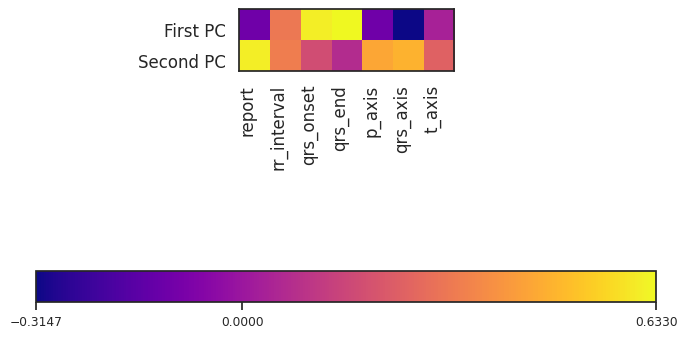

In [53]:
fig = plt.figure(figsize=(8, 4))
plt.imshow(pca.components_, interpolation = 'none', cmap = 'plasma')
feature_names = list(table_data_pca.columns)
plt.gca().set_xticks(np.arange(-.5, len(feature_names)-1));
plt.gca().set_yticks(np.arange(0.5, 2));
plt.gca().set_xticklabels(feature_names, rotation=90, ha='left',fontsize=12);
plt.gca().set_yticklabels(['First PC', 'Second PC'], va='bottom',fontsize=12);
plt.colorbar(orientation='horizontal', ticks=[pca.components_.min(), 0,
                                              pca.components_.max()],pad=0.65);

# MDS

In [54]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS

Text(0, 0.5, 'Second Principal Component')

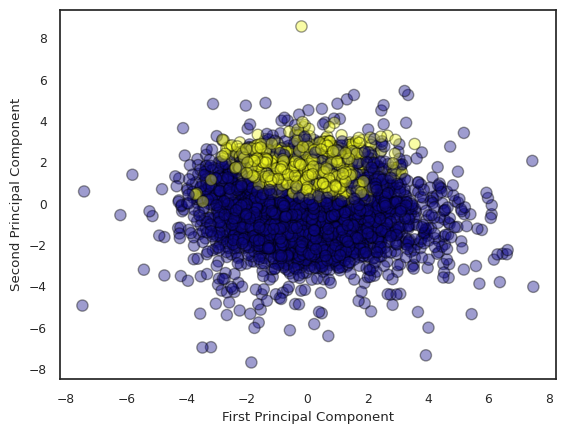

In [73]:
mds = MDS(n_components = 2)
scaled_data_mds = mds.fit_transform(scaled_data)

plt.scatter(scaled_data_mds[:,0], scaled_data_mds[:,1], c=full_df_filtered['Healthy_Status'], cmap='plasma', alpha=0.4, edgecolors='black', s=65);
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

Text(0, 0.5, 'Second Principal Component')

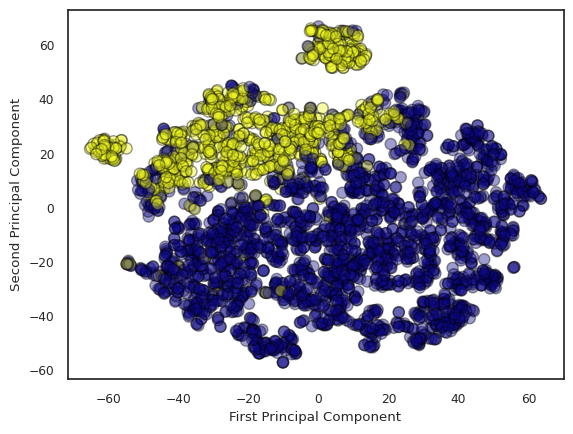

In [72]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state = 0)
scaled_data_mds_tsne = tsne.fit_transform(scaled_data)
plt.scatter(scaled_data_mds_tsne[:,0], scaled_data_mds_tsne[:,1], c=full_df_filtered['Healthy_Status'], cmap='plasma', alpha=0.4, edgecolors='black', s=65);
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import ward, dendrogram, fcluster

In [ ]:

#scaled_data, data_table['Healthy_status'] = make_blobs(random_state = 10)
# n_clusters must be None if distance_threshold is not None
cls = AgglomerativeClustering(n_clusters = 5, affinity='euclidean',linkage='ward', distance_threshold=None)
cls_assignment = cls.fit_predict(scaled_data)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


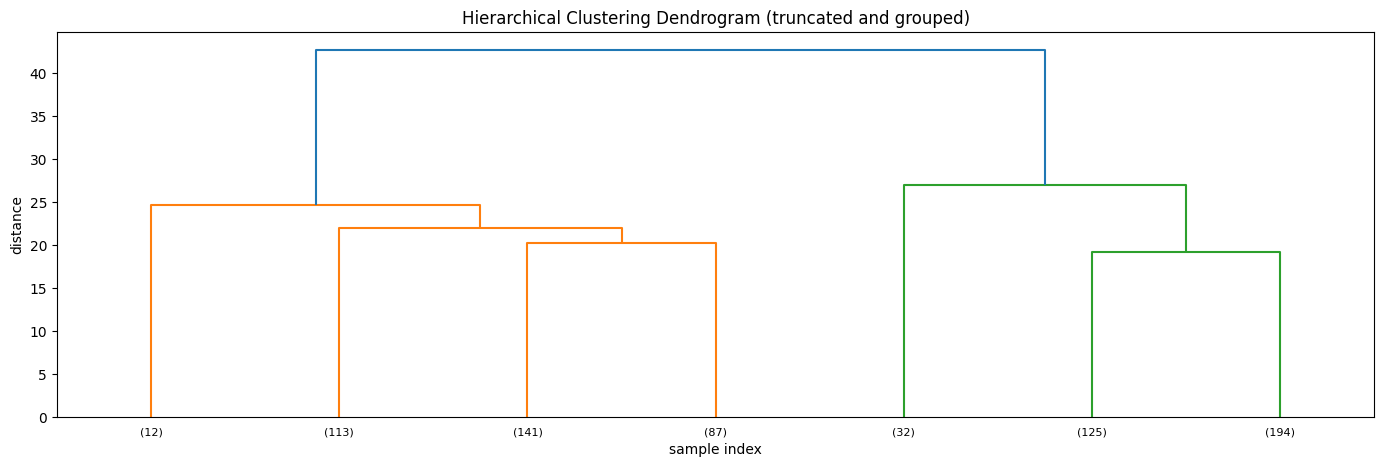

In [ ]:
Z = ward(scaled_data)
plt.figure(figsize=(17,5));
R = dendrogram(Z, truncate_mode='lastp', p=7, orientation='top', leaf_font_size=8)
plt.title('Hierarchical Clustering Dendrogram (truncated and grouped)')
plt.xlabel('sample index')
plt.ylabel('distance')
plt.show()

https://stackoverflow.com/questions/54810800/how-to-get-a-list-of-all-leaves-under-a-node-in-a-dendrogram

In [ ]:
# put X in a dataframe
df = pd.DataFrame()
df['col1']=X[:,0]
df['col2']=X[:,1]

index=[]
for i in range(len(X)):
    elem = 'A' + str(i)
    index.append(elem)

df['index'] = index
print(df.shape)
df.head()

# retrieve elements in each cluster
label = fcluster(Z, 5, criterion='maxclust')

df_clst = pd.DataFrame()
df_clst['index']  = df['index']
df_clst['label']  = label

# print them
for i in range(5):
   elements = df_clst[df_clst['label']==i+1]['index'].tolist()
   size = len(elements)
   print('\n Cluster {}: N = {}  {}'.format(i+1, size, elements))

NameError: name 'fcluster' is not defined

In [ ]:
from scipy.cluster.hierarchy import fcluster
fl = fcluster(Z,5,criterion='maxclust')

In [ ]:
R

{'icoord': [[25.0, 25.0, 35.0, 35.0],
  [15.0, 15.0, 30.0, 30.0],
  [5.0, 5.0, 22.5, 22.5],
  [55.0, 55.0, 65.0, 65.0],
  [45.0, 45.0, 60.0, 60.0],
  [13.75, 13.75, 52.5, 52.5]],
 'dcoord': [[0.0, 20.250716396171867, 20.250716396171867, 0.0],
  [0.0, 22.006139199097237, 22.006139199097237, 20.250716396171867],
  [0.0, 24.635641196702398, 24.635641196702398, 22.006139199097237],
  [0.0, 19.146048741900454, 19.146048741900454, 0.0],
  [0.0, 27.017808675252834, 27.017808675252834, 19.146048741900454],
  [24.635641196702398,
   42.71244083393276,
   42.71244083393276,
   27.017808675252834]],
 'ivl': ['(12)', '(113)', '(141)', '(87)', '(32)', '(125)', '(194)'],
 'leaves': [1379, 1391, 1398, 1400, 1389, 1396, 1399],
 'color_list': ['C1', 'C1', 'C1', 'C2', 'C2', 'C0'],
 'leaves_color_list': ['C1', 'C1', 'C1', 'C1', 'C2', 'C2', 'C2']}

In [ ]:
R

{'icoord': [[25.0, 25.0, 35.0, 35.0],
  [15.0, 15.0, 30.0, 30.0],
  [5.0, 5.0, 22.5, 22.5],
  [55.0, 55.0, 65.0, 65.0],
  [45.0, 45.0, 60.0, 60.0],
  [13.75, 13.75, 52.5, 52.5]],
 'dcoord': [[0.0, 20.250716396171867, 20.250716396171867, 0.0],
  [0.0, 22.006139199097237, 22.006139199097237, 20.250716396171867],
  [0.0, 24.635641196702398, 24.635641196702398, 22.006139199097237],
  [0.0, 19.146048741900454, 19.146048741900454, 0.0],
  [0.0, 27.017808675252834, 27.017808675252834, 19.146048741900454],
  [24.635641196702398,
   42.71244083393276,
   42.71244083393276,
   27.017808675252834]],
 'ivl': ['(12)', '(113)', '(141)', '(87)', '(32)', '(125)', '(194)'],
 'leaves': [1379, 1391, 1398, 1400, 1389, 1396, 1399],
 'color_list': ['C1', 'C1', 'C1', 'C2', 'C2', 'C0'],
 'leaves_color_list': ['C1', 'C1', 'C1', 'C1', 'C2', 'C2', 'C2']}

In [ ]:
import scipy.cluster.hierarchy as sch

In [ ]:
linkage_matrix = sch.average(scaled_data)
rootnode, nodelist = sch.to_tree(linkage_matrix, rd=True)
leaves = sch.leaves_list(linkage_matrix)
print(linkage_matrix[3,:])
#sch.dendrogram(linkage_matrix);

[6.48000000e+02 6.49000000e+02 1.62090411e-01 2.00000000e+00]


In [ ]:
R

{'icoord': [[25.0, 25.0, 35.0, 35.0],
  [15.0, 15.0, 30.0, 30.0],
  [5.0, 5.0, 22.5, 22.5],
  [55.0, 55.0, 65.0, 65.0],
  [45.0, 45.0, 60.0, 60.0],
  [13.75, 13.75, 52.5, 52.5]],
 'dcoord': [[0.0, 20.250716396171867, 20.250716396171867, 0.0],
  [0.0, 22.006139199097237, 22.006139199097237, 20.250716396171867],
  [0.0, 24.635641196702398, 24.635641196702398, 22.006139199097237],
  [0.0, 19.146048741900454, 19.146048741900454, 0.0],
  [0.0, 27.017808675252834, 27.017808675252834, 19.146048741900454],
  [24.635641196702398,
   42.71244083393276,
   42.71244083393276,
   27.017808675252834]],
 'ivl': ['(12)', '(113)', '(141)', '(87)', '(32)', '(125)', '(194)'],
 'leaves': [1379, 1391, 1398, 1400, 1389, 1396, 1399],
 'color_list': ['C1', 'C1', 'C1', 'C2', 'C2', 'C0'],
 'leaves_color_list': ['C1', 'C1', 'C1', 'C1', 'C2', 'C2', 'C2']}

# Affinity propagation

In [ ]:
from sklearn import metrics
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import adjusted_rand_score

In [ ]:
def plot_connected_points(X, labels, centers, cmap):
    for i in range(len(X)):
        color = cmap(labels[i] / len(centers))
        plt.plot([X[i, 0], centers[labels[i], 0]], [X[i, 1], centers[labels[i], 1]], c=color, alpha=0.8)

In [ ]:
sk_ap = AffinityPropagation()
sk_ap_pred_res = sk_ap.fit_predict(scaled_data)
sk_ap_ari = adjusted_rand_score(table_data['Healthy_Status'], sk_ap_pred_res)
print(f'Adjusted Rand Score for sk AffinityPropagation: {sk_ap_ari}', '', sep='\n')
print('Number of clusters = ', np.max(sk_ap_pred_res))
#print('prediction', sk_ap_pred_res, sep='\n')

Adjusted Rand Score for sk AffinityPropagation: 0.0032783107337274802

Number of clusters =  50


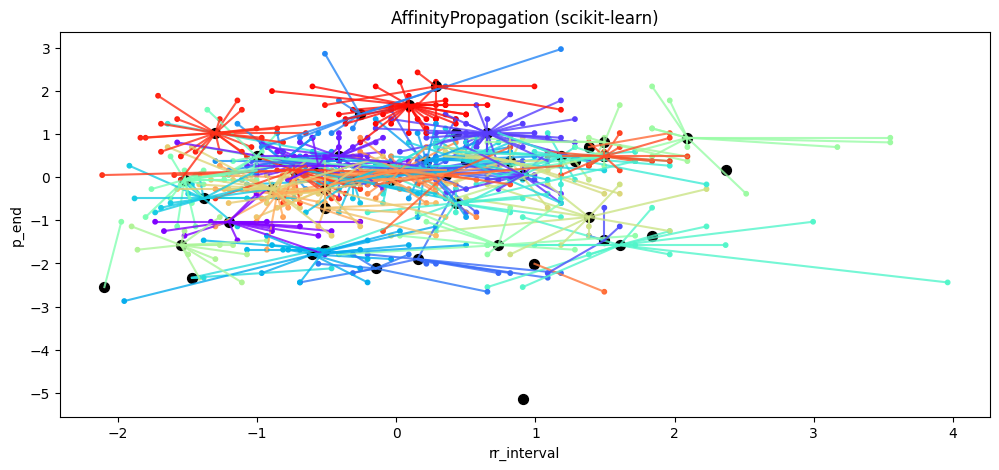

In [ ]:
plt.figure(figsize=(12, 5))

plt.scatter(scaled_data[:, 0], scaled_data[:, 1], c=sk_ap_pred_res, cmap='rainbow', s=10)
plt.scatter(sk_ap.cluster_centers_[:, 0], sk_ap.cluster_centers_[:, 1], c='black', s=50)
plt.title('AffinityPropagation (scikit-learn)')
plt.xlabel(table_data.columns[1])
plt.ylabel(table_data.columns[2])

plot_connected_points(scaled_data, sk_ap_pred_res, sk_ap.cluster_centers_, plt.cm.rainbow)

plt.show()

# Agglomerative Clustering

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

from sklearn.cluster import AgglomerativeClustering

In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    #plt.figure(figsize=(17,5));
    dendrogram(linkage_matrix, **kwargs)
    plt.rcParams["figure.figsize"] = (17,5)
    plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    plt.show()



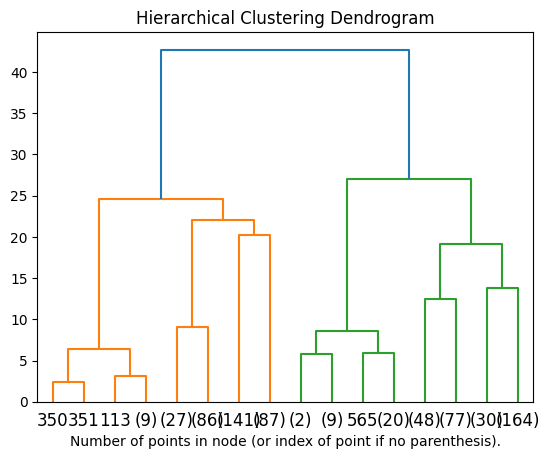

In [ ]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(scaled_data)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
#

# Сравнение ML алгоритмов

In [ ]:
table_data.columns

Index(['Healthy_Status', 'rr_interval', 'p_onset', 'p_end', 'qrs_onset',
       'qrs_end', 'p_axis', 'qrs_axis'],
      dtype='object')

In [ ]:
clf_index = 0
feature_indexes = [4, 7]

table_data_clf = (table_data.values[:,feature_indexes],
                  table_data[table_data.columns[clf_index]])

In [ ]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

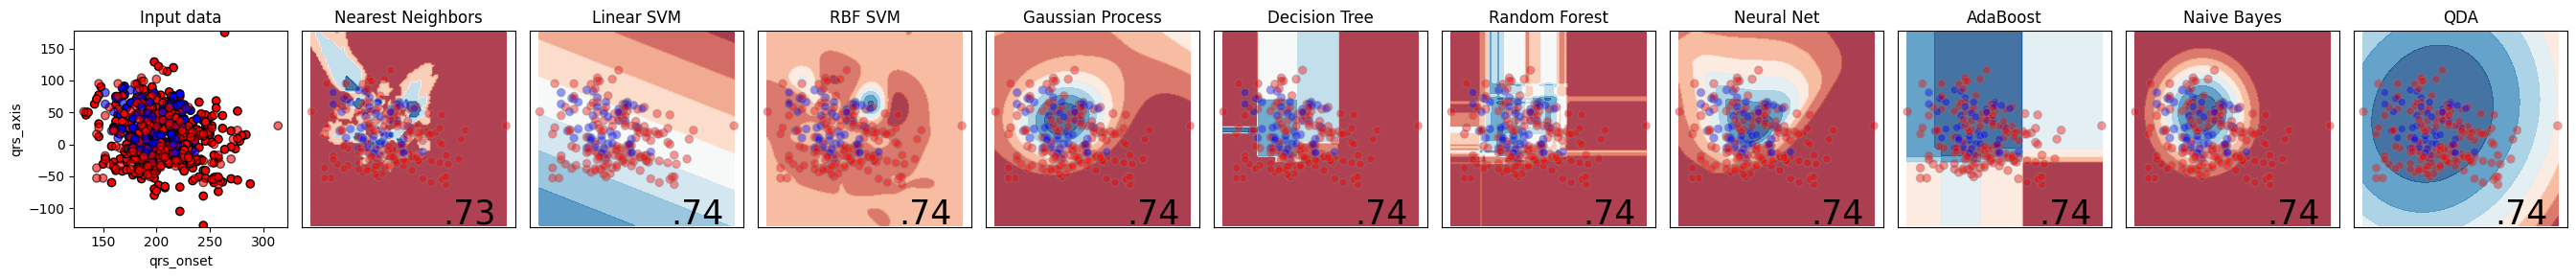

In [ ]:

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=42),
    SVC(gamma=2, C=1, random_state=42),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1, random_state=42
    ),
    MLPClassifier(max_iter=1000, random_state=42),
    AdaBoostClassifier(algorithm="SAMME", random_state=42),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]


datasets = [
    #make_moons(noise=0.3, random_state=0),
    #make_circles(noise=0.2, factor=0.5, random_state=1),
    #linearly_separable,
    table_data_clf
]

figure = plt.figure(figsize=(27, 3))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    #x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    #y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    x_range = abs(X[:, 0].max()) - abs(X[:, 0].min())
    y_range = abs(X[:, 1].max()) - abs(X[:, 1].min())

    x_min, x_max = X[:, 0].min() - 0.05*x_range, X[:, 0].max() + 0.05*x_range
    y_min, y_max = X[:, 1].min() - 0.05*y_range, X[:, 1].max() + 0.05*y_range


    # just plot the dataset first
    cm = plt.cm.RdBu
    # red and blue = 0000FF color. Red = 0. Blue = 1 status
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    #ax.set_xticks(())
    #ax.set_yticks(())
    ax.set_xlabel(table_data.columns[feature_indexes[0]])
    ax.set_ylabel(table_data.columns[feature_indexes[1]])
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)

        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        DecisionBoundaryDisplay.from_estimator(
            clf, X, cmap=cm, alpha=0.8, ax=ax, eps=0.5
        )

        # Plot the training points
        #ax.scatter(
        #    X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        #)
        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="grey",
            alpha=0.4,
        )

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            x_max - x_range*0.1,
            y_min + y_range*0.1,
            ("%.2f" % score).lstrip("0"),
            size=25,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
plt.show()

In [ ]:
datasets

[(array([[ 0, 81],
         [ 0, 77],
         [ 1, 79],
         ...,
         [ 1, 70],
         [ 1, 43],
         [ 0, 30]]),
  0       0
  1       0
  2       1
  3       1
  6       1
         ..
  9994    1
  9995    1
  9996    1
  9998    1
  9999    0
  Name: Healthy_Status, Length: 7046, dtype: int64)]

# Примеры классификаторов на модельных задачах

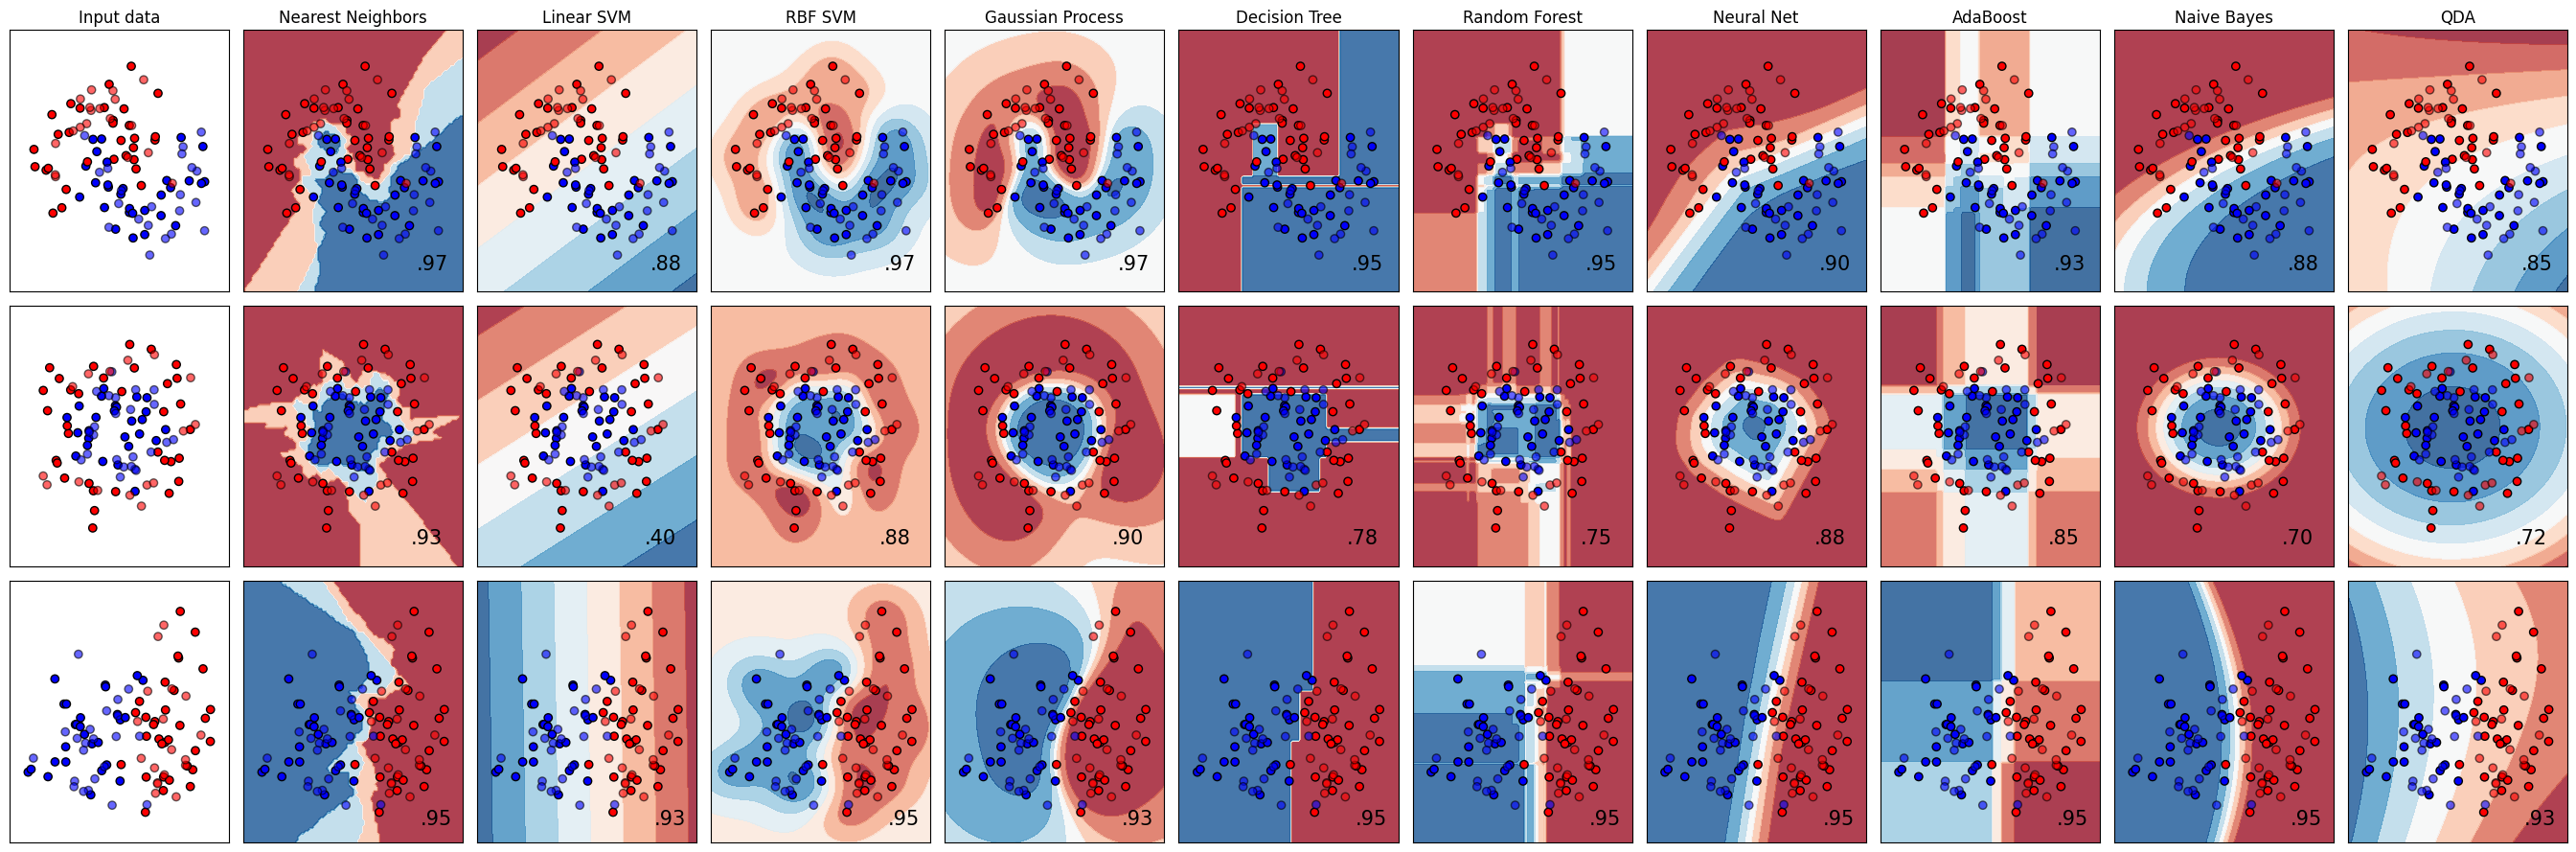

In [ ]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=42),
    SVC(gamma=2, C=1, random_state=42),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1, random_state=42
    ),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    AdaBoostClassifier(algorithm="SAMME", random_state=42),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    make_moons(noise=0.3, random_state=0),
    make_circles(noise=0.2, factor=0.5, random_state=1),
    linearly_separable,
]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # just plot the dataset first
    cm = plt.cm.RdBu
    # red and blue = 0000FF color. Red = 0, Blue = 1 status
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)

        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        DecisionBoundaryDisplay.from_estimator(
            clf, X, cmap=cm, alpha=0.8, ax=ax, eps=0.5
        )

        # Plot the training points
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        )
        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            x_max - 0.3,
            y_min + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
plt.show()